# __Trabalho Prático 1 - Classificador Supervisionado__

Desenvolvendo um classificador supervisionado utilizando conceitos de geometria computacional.

#### __Disciplina:__ Algoritmos II

#### __Grupo:__
Vinicius Silva Gomes - 2021421869

Mirna Mendonça e Silva - 2021421940

Daniel Barreto Torres - 2018432952

---

## __Introdução__
O objetivo principal do trabalho é implementar um classificador supervisionado a partir de conceitos e algoritmos de geometria computacional. Assim, dado dois conjuntos de pontos no plano e suas respectivas classificações, devemos construir uma regressão linear a partir dos conjuntos e classificar novas amostras desconhecidas. Esses conjuntos podem ser arbitrários ou vindos de datasets externos. A título deste trabalho, será apresentado, inicialmente, um exemplo mais simples, com poucos pontos e de modo que todo o processo possa ser amplamente distrinchado e entendido e, após isso, uma etapa de experimentação com datasets externos vindos do repositório de datasets KEEL, visando avaliar a qualidade do método de classificação proposto.

Nesse arquivo encontram-se o código fonte de todas funções executadas pelo programa, assim como a explicação de cada uma delas (em alto ou baixo nível, de acordo com a necessidade), além da documentação de como foi feita a Modelagem Computacional do problema, como funcionou a etapa de Experimentação e, por fim, quais foram as Conclusões e os Resultados obtidos ao final dos experimentos. Para executar o programa basta executar cada célula presente neste _notebook_ e avaliá-lo a partir dos retornos do código/gráficos e resultados.

## __Modelagem Computacional__
Para construir um classificador baseado em algoritmos geométricos utilizando apenas os atributos dos conjuntos de dados, foi utilizada uma abordagem muito simples e intuitiva. Primeiramente, serão definidas as envoltórias convexas para cada classe do conjunto, considerando uma 2-tupla de atributos do dataset (coordenadas X e Y para definir um ponto no plano). Após isso, haverá a verificação se essas envoltórias são linearmente separáveis. Caso não sejam, é sinal de que é impossível classificar as amostras através de um classificador linear, baseando-se nos atributos escolhidos. Caso sejam, significa que a reta de regressão pode ser traçada e que novas amostras podem ser classificadas a partir dela. Desse modo, a reta de regressão será definida a partir dos pontos mais próximos entre as envoltórias. A reta que cruza o ponto médio do segmento definido por esses pontos, construindo um ângulo de 90º com o segmento, será a regressão linear que irá possibilitar a classificação de amostras cujo _ground truth_ não seja conhecido.

#### __Classes__

Para simplificar e generalizar o acesso aos atributos de cada conjunto de dados, a classe ___Sample___ foi criada contendo as coordenadas $(x, y)$ da posição da amostra no plano e o _ground truth_ para aquela amostra. Dessa forma, o acesso a esses atributos pode ser generalizado, o que facilita a manipulação dos datasets, visto que cada um deles teria nomes de atributos diferentes destinados a cada um dos eixos do plano. De fato, na fase de experimentação, um dos primeiros passos é mapear todas as instâncias do dataset para uma instância de Sample, facilitando demais a manipulação dos pontos e a execução dos métodos.

#### __Envoltórias Convexas__

Definidas as classes principais para representar os pontos, podem ser estudados, então, os algoritmos geométricos utilizados em cada etapa do processo de classificação. Para computar as envoltórias convexas, será utilizado o algoritmo Graham Scan, que é capaz de montar a envoltória convexa para um conjunto arbitrário de pontos em tempo $\mathcal{O}(n \log{}n)$. De maneira simplificada, o Graham Scan ordena os pontos do conjunto a partir da coordenada polar em relação a um âncora definido previamente (elemento com menor coordenada y e mais a esquerda), e insere os pontos do conjunto em uma pilha, seguindo o critério de que toda nova inserção deve realizar um giro anti-horário em relação aos dois elementos anteriores na pilha. Caso o giro seja em sentido horário, o elemento ao topo da pilha deve ser desempilhado e a comparação é refeita, até que um giro em sentido anti-horário seja obtido. Dessa forma, após processar todos os pontos, o algoritmo garante que o polígono formado será convexo e que todos os pontos que não são vértices dele, se encontram dentro do polígono.

#### __Separabilidade Linear com um algoritmo de Varredura__

Além desse algoritmo, para verificar se as duas envoltórias são linearmente separáveis, podemos utilizar o algoritmo de varredura linear para verificar interseção entre um conjunto de segmentos. Desse modo, as duas envoltórias serão linearmente separáveis apenas se as únicas interseções presentes no conjunto de segmentos que definem ambas as envoltórias forem entre os segmentos da própria envoltória. Esse algoritmo é capaz de fazer isso a partir da ordenação dos segmentos e, além disso, utiliza uma árvore binária balanceada (AVL ou Rubro-Negra, por exemplo) para facilitar as comparações que são necessárias. Dessa maneira, no total, a complexidade temporal do algoritmo, assim como para o Graham Scan, é $\mathcal{O}(n \log{}n)$. Então, caso seja detectado a interseção entre dois segmentos que não pertencem a mesma classe (interseção entre segmentos de envoltórias diferentes), significa que as envoltórias não são linearmente separáveis e, portanto, não conseguimos classificar as amostras a partir de um classificador linear.

#### __Primitivas Geométricas__

Para realizar essas computações, especialmente as comparações de coordenadas polares ao construir a envoltória convexa e verificar a separabilidade linear das envoltórias, serão utilizadas apenas as primitivas geométricas (posição relativa entre segmentos e o método para verificar se há interseção entre dois segmentos), de modo a evitar ao máximo divisões, funções trigonométricas, etc; evitando, com isso, imprecisões numéricas e problemas como _underflow_ e/ou _overflow_.

A posição relativa entre segmentos pode ser calculada a partir do produto vetorial entre os segmentos e o sinal do resultado analisado. Caso seja igual a zero, os segmentos são colineares, caso seja negativo o primeiro segmento está em sentido anti-horário em relação ao segundo e, por fim, caso seja positivo o primeiro segmento está em sentido horário em relação ao segundo.

Ademais, a interseção entre segmentos pode ser calculada utilizando a primitiva de posição relativa, comparando-se os terminais de cada segmento de modo que, o segmento formado pelo terminal de deles conectado aos terminais do outro segmento fiquem em posições relativas alternadas (um está em sentido horário e o outro em sentido anti-horário). Repetindo o processo para o outro segmento, caso os segmentos também estejam em posições relativas alternadas, é possível ter certeza que esses segmentos se cruzam em algum ponto. Fora isso, o outro caso a ser analisado é quando um dos terminais de um segmento é colinear ao outro. Nesse caso, além desses testes, deve ser verificado se o terminal colinear está contido dentro do outro segmento. Caso sim, há interseção e caso não, não há.

#### __Reta da Regressão Linear__

Por último, a regressão linear deve ser calculada. Para tanto, os dois vértices mais próximos entre as envoltórias são selecionados, supomos aqui $a = (x_a, y_a)$ e $b = (x_b, y_b)$, e o segmento $\overline{ab}$ que conecte ambos será traçado. A reta $r$ será definida a partir dele da seguinte forma: ela deverá ter direção inversa em relação ao segmento que conecta os pontos e cortá-lo no ponto médio. Usando conceitos básicos de geometria analítica, podemos calcular os coeficientes $\beta_0$ e $\beta_1$ (coeficiente linear e angular, respectivamente) da reta a partir das seguintes equações:

$$\beta_1 = -\frac{1}{\frac{y_b - y_a}{x_b - x_a}}$$

$$\beta_0 = (y_a + \frac{y_b - y_a}{2}) - \beta_1 \cdot (x_a + \frac{x_b - x_a}{2})$$

A primeira equação define o $\beta_1$, coeficiente angular da reta, a partir do coeficiente angular da reta que sobrepõe o segmento formado pelos pontos $a$ e $b$. Para tanto, podemos obter o coeficiente angular dessa reta, através da equação $m = \frac{y_b - y_a}{x_b - x_a}$, e inverter esse resultado, conseguindo a equação $\beta_1 = -\frac{1}{m}$ (equivalente a equação definida inicialmente). A segunda equação, por sua vez, obtém o $\beta_0$ a partir do $\beta_1$ obtido anteriormente e do ponto conhecido que essa reta cruza: o ponto médio do segmento $\overline{ab}$. Dessa forma, é possível obter o $\beta_0$ e, com isso, conseguir os dois coeficientes necessários para determinar a regressão linear.

Além disso, é necessário enfatizar que, caso as subtrações $x_b - x_a$ ou $y_b - y_a$ sejam iguais a zero, significa que os pontos estão sob a mesma coordenada x ou y e diferem apenas na outra coordenada. Nesse caso, a reta de regressão ou é uma reta horizontal, paralela ao eixo das abscissas, ou é uma reta vertical, paralela ao eixo das ordenadas. Assim, a reta tem $\beta_1 = 0$ (reta horizontal) para o primeiro caso e a reta é $x = x_a + \frac{x_b - x_a}{2}$ (reta vertical) para o segundo caso.

Com a reta da regressão linear em mãos, para classificar uma amostra basta calcular o $\hat{y}$ a partir de seu $x_0$ e comparar com o $y_0$ original da amostra. Se ambos forem iguais a amostra não pode ser classificada, pois está em cima da regressão. Caso não, se $y_0 < \hat{y}$ a amostra receberá a _label_ da envoltória respectiva a esse lado da regressão. Da mesma forma, se $y_0 > \hat{y}$ a amostra receberá a _label_ da outra envoltória que compôs a regressão linear. Dessa forma, é possível criar um modelo de classificação supervisionado capaz de classificar pontos a partir de um conjunto cujas classes sejam linearmente separáveis e extender seu uso para datasets externos, presentes na _Web_. No caso dos datasets, a etapa de processamento do conjunto é um pouco mais complexa. Essas nuânces serão melhor discutidas na seção de Experimentação do trabalho.

## __Implementação__
A implementação da solução para o problema foi feita em Python e o códugo fonte para as funções produzidas pode ser observado a seguir. As funções apresentam breves comentários a respeito de detalhes de sua implementação e o que cada trecho faz no código. 

In [1]:
# Importando as bibliotecas e configurações iniciais delas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bintrees import FastRBTree

from functools import cmp_to_key

from math import sqrt, floor

import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys

plt.rcParams['figure.figsize']  = (12, 6)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 1

plt.ion()
plt.style.use('seaborn-colorblind')

### __Classes Principais__

Definição das classes usadas ao longo do algoritmo, para facilitar a classificação e a manipulação, de maneira geral, dos pontos ao longo dos algoritmos.

In [2]:
# Definição da classe Sample

class Sample:
    def __init__(self, x = None, y = None, label = None):
        self.x = x
        self.y = y
        self.label = label
        
    def __str__(self):
        return f"({self.x}, {self.y}) - {self.label}"

### __Métodos Auxiliares e de Visualização__

Aqui são definidas as funções de plotagem dos pontos, envoltórias, classificador, etc. Além disso, são definidas as funções auxiliares usadas de maneira intermediária pelos algoritmos principais que computam as envoltórias, a varredura linear, o classificador e o processo de classificação, etc.

In [3]:
# Métodos para visualização das etapas da classificação

# Plota os dois conjuntos no plano
def plot_sets(set_a, set_b, label_a = "", label_b = "", title = "Conjuntos no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    plt.axis('equal')
    
    plt.xlim([min(item.x for item in set_a + set_b) - 1, max(item.x for item in set_a + set_b) + 1])
    plt.ylim([min(item.y for item in set_a + set_b) - 1, max(item.y for item in set_a + set_b) + 1])
        
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()
    
# Plota os conjuntos e a envoltória convexa de cada conjunto no plano
def plot_hulls(set_a, set_b, hull_a, hull_b, label_a = "", label_b = "", title = "Envoltórias Convexas no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    hull_a.append(hull_a[0])
    hull_b.append(hull_b[0])
    
    plt.plot([item.x for item in hull_a], [item.y for item in hull_a], "-g")
    plt.plot([item.x for item in hull_b], [item.y for item in hull_b], "-b")
    
    plt.axis('equal')
    
    plt.xlim([min(item.x for item in hull_a + hull_b) - 1, max(item.x for item in hull_a + hull_b) + 1])
    plt.ylim([min(item.y for item in hull_a + hull_b) - 1, max(item.y for item in hull_a + hull_b) + 1])
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()
    
# Plota os conjuntos, a envoltória convexa de cada um e a reta do classificador
def plot_classifier(set_a, set_b, hull_a, hull_b, b0, b1, is_vertical, vertical_coord,
                    point_a, point_b, label_a = "", label_b = "", title = "Envoltórias e Regressão Linear no plano"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    hull_a.append(hull_a[0])
    hull_b.append(hull_b[0])
    
    plt.plot([item.x for item in hull_a], [item.y for item in hull_a], "-g")
    plt.plot([item.x for item in hull_b], [item.y for item in hull_b], "-b")
    
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "ok")
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "-k")
    
    midpoint = ((point_a.x + (point_b.x - point_a.x) / 2), (point_a.y + (point_b.y - point_a.y) / 2))
    
    plt.plot(midpoint[0], midpoint[1], "ok")
    
    if is_vertical:
        plt.axvline(x = vertical_coord, color = 'r')
    else:
        line_x = np.linspace(min(item.x for item in hull_a + hull_b) - 5, max(item.x for item in hull_a + hull_b) + 5, 100)
        line_y = b1 * line_x + b0
        plt.plot(line_x, line_y, '-r')
    
    plt.axis('equal')
    
    plt.xlim([min(item.x for item in hull_a + hull_b) - 1, max(item.x for item in hull_a + hull_b) + 1])
    plt.ylim([min(item.y for item in hull_a + hull_b) - 1, max(item.y for item in hull_a + hull_b) + 1])
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()
    
# Plota os conjuntos, a envoltória convexa de cada um, a reta do classificador e o resultado para as classificações realizadas
def plot_classified_data(set_a, set_b, hull_a, hull_b, b0, b1, is_vertical, vertical_coord,
                         point_a, point_b, samples, label_a = "", label_b = "",
                         title = "Resultado após as classificações"):
    plt.scatter([item.x for item in set_a], [item.y for item in set_a], color="green", label=label_a)
    plt.scatter([item.x for item in set_b], [item.y for item in set_b], color="blue", label=label_b)
    
    hull_a.append(hull_a[0])
    hull_b.append(hull_b[0])
    
    plt.plot([item.x for item in hull_a], [item.y for item in hull_a], "-g")
    plt.plot([item.x for item in hull_b], [item.y for item in hull_b], "-b")
    
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "ok")
    plt.plot([point_a.x, point_b.x], [point_a.y, point_b.y], "-k")
    
    midpoint = ((point_a.x + (point_b.x - point_a.x) / 2), (point_a.y + (point_b.y - point_a.y) / 2))
    
    plt.plot(midpoint[0], midpoint[1], "ok")
    
    if is_vertical:
        plt.axvline(x = vertical_coord, color = 'r')
    else:
        line_x = np.linspace(min(item.x for item in hull_a + hull_b) - 5, max(item.x for item in hull_a + hull_b) + 5, 100)
        line_y = b1 * line_x + b0
        plt.plot(line_x, line_y, '-r')
        
    for sample in samples:
        if sample[3] == label_a:
            if sample[2] == sample[3]:
                plt.plot([sample[0]], [sample[1]], "Xy")
            else:
                plt.plot([sample[0]], [sample[1]], "Xc")
        else:
            if sample[2] == sample[3]:
                plt.plot([sample[0]], [sample[1]], "Xc")
            else:
                plt.plot([sample[0]], [sample[1]], "Xy")
    
    plt.axis('equal')
    
    plt.xlim([min(item.x for item in hull_a + hull_b) - 1, max(item.x for item in hull_a + hull_b) + 1])
    plt.ylim([min(item.y for item in hull_a + hull_b) - 1, max(item.y for item in hull_a + hull_b) + 1])
    
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    
    plt.legend(loc="upper left")
        
    plt.show()

In [4]:
# Métodos auxiliares

# Posição relativa do segmento pr em relação ao segmento pq
def relative_position(p, q, r):
    # Produto vetorial dos segmentos pq e pr
    pos = ((r.x - q.x) * (q.y - p.y)) - ((r.y - q.y) * (q.x - p.x))
    
    if pos == 0:
        return 0 # colinear
    elif pos > 0:
        return 1 # sentido horário
    else:
        return -1 # sentido antihorário

## Envoltória Convexa

# Encontra o ponto com a menor coordenada y, mais a esquerda possível
def find_minor_point(points):
    index = -1
    min_y = sys.maxsize
    
    for idx, point in enumerate(points):
        if point.y < min_y:
            index = idx
            min_y = point.y
        elif point.y == min_y:
            if point.x < points[index].x:
                index = idx
                
    return (points[index], index)

# Distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    distance = sqrt(((p1.x - p2.x) ** 2) + ((p1.y - p2.y) ** 2))
    
    return distance
    
# Redefine a ordenação realizada pela função padrão do Python para ordenar a partir da coordenada polar com relação a p0
def polar_sort(p0, p1, p2):
    relative_pos = relative_position(p0, p1, p2)
    
    if relative_pos == 0:
        if euclidean_distance(p0, p1) < euclidean_distance(p0, p2):
            return -1
        else:
            return 1
    else:
        return relative_pos
    
# Remove os pontos que estã sob a mesma coordenada polar em relação a p0, mantendo aquele mais distante em relação a ele
def remove_same_polar_angle(points):
    n = len(points)
    remove = []
    
    for i in range(1, n - 1):
        if relative_position(points[0], points[i], points[i+1]) == 0:
            size_seg_a = euclidean_distance(points[0], points[i])
            size_seg_b = euclidean_distance(points[0], points[i+1])
            
            if size_seg_a < size_seg_b:
                remove.append(points[i])
            else:
                remove.append(points[i+1])
                
    for coord in remove:
        if coord in points:
            points.remove(coord)
        
    return points
    
# Acessa o elemento anterior ao topo da pilha
def next_to_top(hull):
    return hull[-2]

# Acessa o topo da pilha
def top(hull):
    return hull[-1]

def compare_events(event):
    return event[0].x

# Verifica se um ponto está contido dentro de um segmento
def on_segment(p, q, r):
    if r.x >= min(p.x, q.x) and r.x <= max(p.x, q.x):
        if r.y >= min(p.y, q.y) and r.y <= max(p.y, q.y):
            return True
    
    return False

# Verifica se dois segmentos se intersectam
def segments_intersect(p1, p2, p3, p4):
    d1 = relative_position(p3, p4, p1)
    d2 = relative_position(p3, p4, p2)
    d3 = relative_position(p1, p2, p3)
    d4 = relative_position(p1, p2, p4)
    
    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True
    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False
    
## Classificação

# Calcula as métricas de precisão e revocação a partir dos dados obtidos da classificação
def calculate_metrics(result, label_a, label_b):
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    
    for res in result:
        if res[3] == label_a:
            if res[2] == res[3]:
                true_positive += 1
            else:
                false_negative += 1
        else:
            if res[2] == res[3]:
                true_negative += 1
            else:
                false_positive += 1
            
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    return precision, recall
    
# Calcula o F1-Score a partir da precisão e revocação previamente calculados
def calculate_fscore(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

### __Métodos Principais__

In [5]:
# Métodos principais

# Calcula a envoltória convexa para o conjunto de pontos dados
def graham_scan(points):
    # Encontra p0 no conjunto de dados
    p0, idx = find_minor_point(points)
    
    # Troca o p0 de lugar elemento de índice 0 do conjunto
    aux = points[0]
    points[0] = p0
    points[idx] = aux    
    
    # Ordena os elementos restantes a partir da coordenada polar com relação ao elemento p0
    sorted_points = points.copy()
    sorted_points[1:] = sorted(points[1:], key=cmp_to_key(lambda p1, p2: polar_sort(p0, p1, p2)))
    
    # Remove os pontos que possuem o mesmo ângulo polar em relação a p0 (mantém o que está mais longe)
    sorted_points = remove_same_polar_angle(sorted_points.copy())
    
    if(len(sorted_points) < 3):
        print("É impossível montar uma envoltória convexa com o conjunto de pontos fornecido!")
        return
    
    hull = []
    hull.append(sorted_points[0])
    hull.append(sorted_points[1])
    hull.append(sorted_points[2])
    
    for i in range(3, len(sorted_points)):
        while ((len(hull) > 1) and (relative_position(next_to_top(hull), top(hull), sorted_points[i]) != -1)):
            hull.pop()
            
        hull.append(sorted_points[i])
    
    return hull

# Algoritmo para verificar se dois conjuntos de pontos são linearmente separável
def hulls_are_linearly_separable(hull_a, hull_b):
    has_intersection = line_sweep_intersection(hull_a, hull_b)
    
    if has_intersection:
        return False
    else:
        return True

# Algoritmo para a construção do classificador
def make_classifier(hull_a, hull_b, label_a, label_b):
    min_distance = sys.maxsize
    points = (None, None)
    
    # Seleciona os dois pontos, um de cada conjunto, que possuem a menor distância euclidiana entre si
    for point_a in hull_a:
        for point_b in hull_b:
            distance = euclidean_distance(point_a, point_b)

            if distance < min_distance:
                min_distance = distance
                points = (point_a, point_b)
                
    # Recupera os pontos mais próximos em cada conjunto
    point_a, point_b = points
    
    is_vertical = False
    vertical_coord = None
    
    if point_b.x - point_a.x == 0:
        b1 = 0
        bo = ((point_b.y - point_a.y) / 2) + point_a.y
    elif point_b.y - point_a.y == 0: # caso onde o classificador é paralelo ao eixo X
        is_vertical = True
        vertical_coord = ((point_b.x - point_a.x) / 2) + point_a.x
        b1 = None
        b0 = None
    else:
        # Calcula o coeficiente angular da reta
        m = (point_b.y - point_a.y) / (point_b.x - point_a.x)
        b1 = -1 / m
        
        # Calcula o coeficiente linear da reta
        b0 = ((point_b.y - point_a.y) / 2) + point_a.y - b1 * (((point_b.x - point_a.x) / 2) + point_a.x)
        
    # Caso a reta seja vertical
    if is_vertical:
        if point_a.x == vertical_coord or point_b.x == vertical_coord:
            print("Os pontos mais próximos de cada conjunto estão em cima da reta do classificador!")
            return
        
        # up_label é o lado direito e down_label é o lado esquerdo
        if point_a.x < vertical_coord:
            up_label = point_b.label
            down_label = point_a.label
        else:
            up_label = point_a.label
            down_label = point_b.label
    else:
        y_a_hat = b1 * point_a.x + b0
        y_b_hat = b1 * point_b.x + b0

        if point_a.y == y_a_hat or point_b.y == y_b_hat:
            print("Os pontos mais próximos de cada conjunto estão em cima da reta do classificador!")
            return

        if point_a.y < y_a_hat:
            up_label = point_b.label
            down_label = point_a.label
        else:
            up_label = point_a.label
            down_label = point_b.label
            
    # Retorna o coeficiente linear, o coeficiente angular, se a reta é vertical e a coordenada caso seja, 
    # qual a classificação das amostras acima da reta e abaixo
    return b0, b1, is_vertical, vertical_coord, point_a, point_b, up_label, down_label

# Utiliza os coeficientes da reta para classificar uma amostra
def classify_sample(b0, b1, is_vertical, vertical_coord, up_label, down_label, sample):
    if is_vertical:
        if sample.x == vertical_coord:
            return False
        elif sample.x > vertical_coord:
            return up_label
        else:
            return down_label
    else:
        y_hat = b1 * sample.x + b0

        if sample.y == y_hat:
            return False
        elif sample.y < y_hat:
            return down_label
        else:
            return up_label

### __Exemplos básicos do processo de classificação__

Aqui estão descritos alguns exemplos simples, com dados sintéticos de como é o funcionamento do classificador para alguns cenários diferentes de dados e de inclinação da reta do classificador. O primeiro exemplo é mais simples, onde os dados são linearmente separáveis e o conjunto sintético é pequeno. Já o segundo exemplo, por mais que os conjuntos sejam muito semelhantes ao do primeiro exemplo, alguns pontos foram deslocados para que os conjuntos não sejam mais linearmente separáveis. Dessa forma, é possível ver o funcionamento do método que realiza a verificação da separabilidade linear.

#### __Conjuntos sintéticos linearmente separáveis__

Para esse conjunto de dados, como pode ser observado, não há interseção entre segmentos dos conjuntos. Dessa forma, poderá ser observado como todo o processo de classificação acontece e, ao final, algumas amostras são classificadas. Esse processo será extendido e ampliado durante a experimentação, para que dados mais complexos sejam usados e métricas que atestem a qualidade do classificador/classificação serão calculadas.

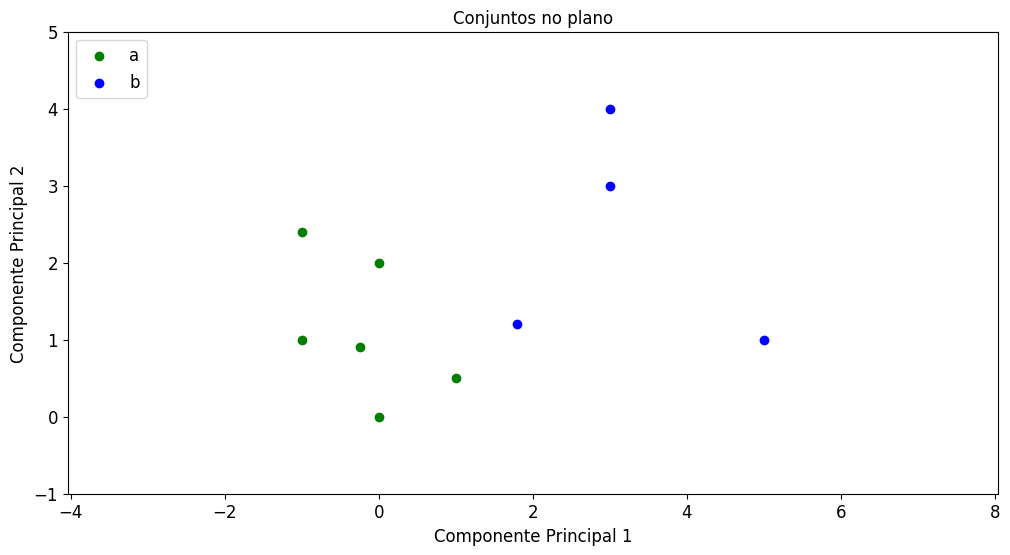

In [6]:
# Conjuntos sintéticos

label_a = "a"
label_b = "b"

set_a = [Sample(0, 2, label_a), Sample(0, 0, label_a), Sample(-0.25, 0.9, label_a), Sample(-1, 2.4, label_a), Sample(1, 0.5, label_a), Sample(-1, 1, label_a)]
set_b = [Sample(1.8, 1.2, label_b), Sample(3, 4, label_b), Sample(5, 1, label_b), Sample(3, 3, label_b)]

plot_sets(set_a, set_b, label_a, label_b)

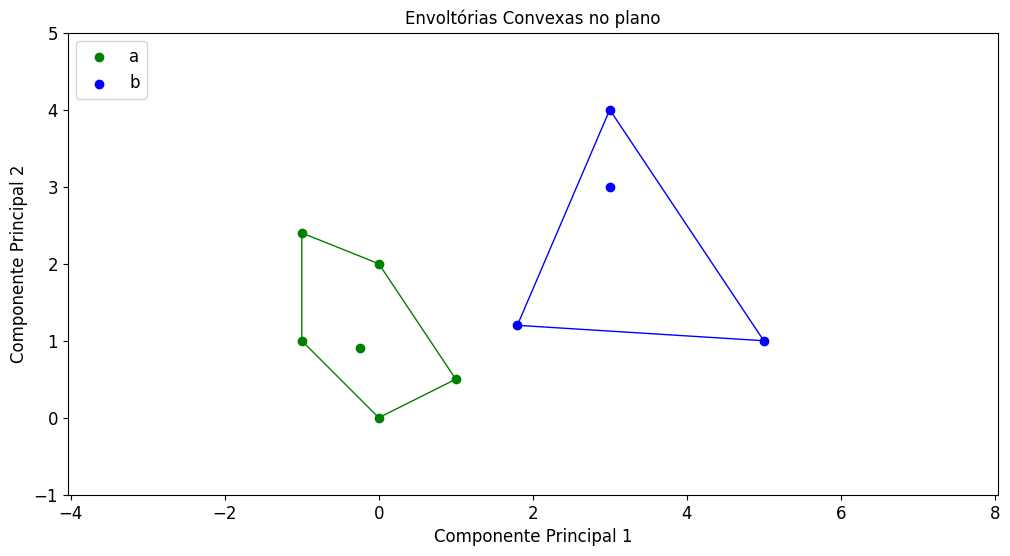

In [7]:
# Envoltórias Convexas

hull_a = graham_scan(set_a)
hull_b = graham_scan(set_b)

plot_hulls(set_a, set_b, hull_a, hull_b, label_a, label_b)

In [8]:
# Verificar se as duas envoltórias são linearmente separáveis

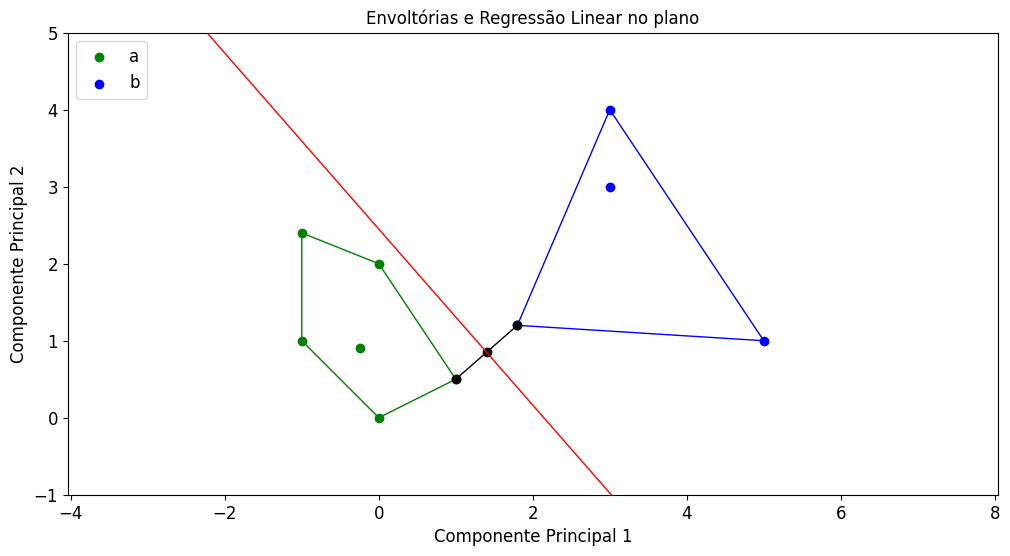

In [9]:
# Classificador
b0, b1, is_vertical, vertical_coord, point_a, point_b, up_label, down_label = make_classifier(hull_a, hull_b, label_a, label_b)

plot_classifier(set_a, set_b, hull_a, hull_b, b0, b1, is_vertical, vertical_coord, point_a, point_b, label_a, label_b)

In [10]:
# Exemplo de classificação de uma amostra

sample = Sample(-2, 3, label_a)

print(f"Coordenadas da amostra: ({sample.x}, {sample.y})")

classification = classify_sample(b0, b1, is_vertical, vertical_coord, up_label, down_label, sample)

if classification == False:
    print("Amostra está sob a reta de regressão.")
else:
    if classification == sample.label:
        print(f"A amostra foi classificada corretamente! (Classificação: {classification} - Ground Truth: {sample.label})")
    else:
        print(f"A amostra não foi classificada corretamente. (Classificação: {classification} - Ground Truth: {sample.label})")

Coordenadas da amostra: (-2, 3)
A amostra foi classificada corretamente! (Classificação: a - Ground Truth: a)


#### __Conjuntos sintéticos não linearmente separáveis__

Para esse conjunto de dados, como pode ser observado, há interseção entre segmentos dos conjuntos. Será possível, então, atestar se a função responsável por realizar essa verificação é capaz de perceber as interseções.

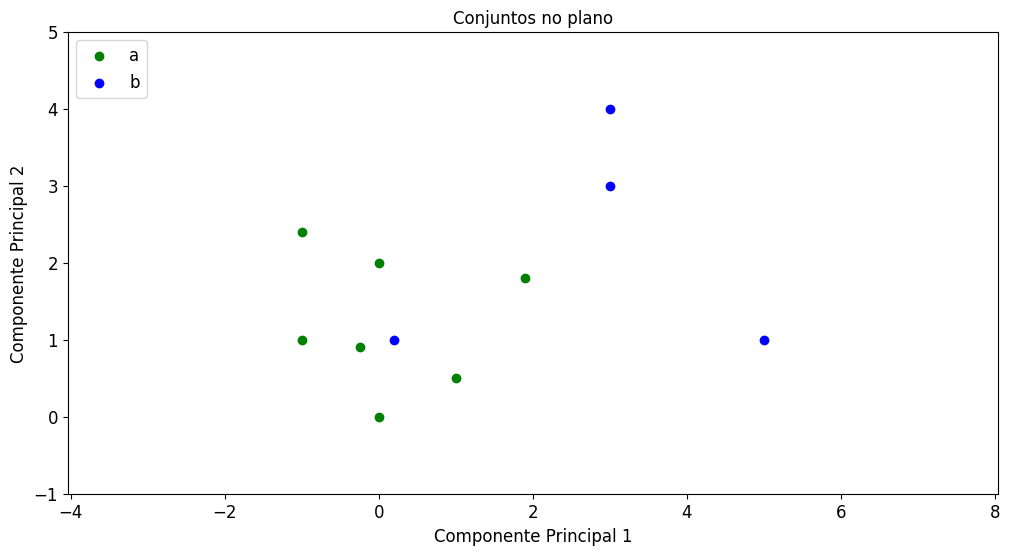

In [11]:
# Conjuntos sintéticos

label_a = "a"
label_b = "b"

set_a = [Sample(0, 2, label_a), Sample(0, 0, label_a), Sample(-0.25, 0.9, label_a), Sample(-1, 2.4, label_a), Sample(1, 0.5, label_a), Sample(-1, 1, label_a), Sample(1.9, 1.8, label_a)]
set_b = [Sample(0.2, 1, label_b), Sample(3, 4, label_b), Sample(5, 1, label_b), Sample(3, 3, label_b)]

plot_sets(set_a, set_b, label_a, label_b)

0 0
1 0.5
1.9 1.8
-1 2.4
-1 1
0.2 1
5 1
3 4


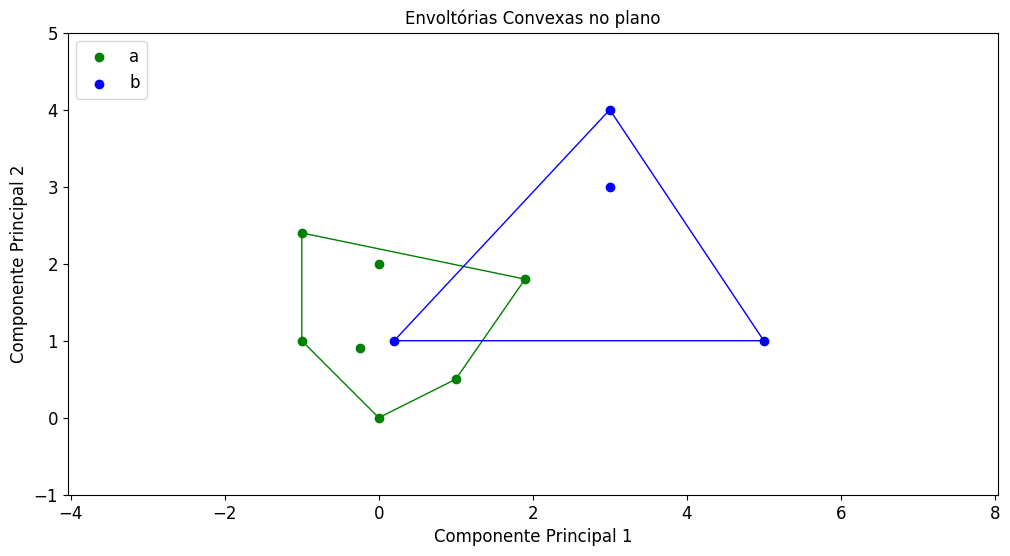

In [12]:
# Envoltórias Convexas

hull_a = graham_scan(set_a)
hull_b = graham_scan(set_b)

def printing(hull):
    for sample in hull:
        print(sample.x, sample.y)

printing(hull_a)
printing(hull_b)

plot_hulls(set_a, set_b, hull_a, hull_b, label_a, label_b)

In [13]:
# Algoritmo da varredura linear para detectar interseção entre um conjunto de pontos
class Segment:
    def __init__(self, start = None, end = None):
        self.start = start
        self.end = end

def line_sweep_intersection(hull_a, hull_b):
    all_points = hull_a + hull_b
    # print("Pontos hull_a:")
    # for point in hull_a:
    #     print(point.x, point.y)
    # print("Pontos hull_b:")
    # for point in hull_b:
    #     print(point.x, point.y)
    # print("Pontos:")
    # for point in all_points:
    #     print(point.x, point.y)
    segments = [];
    events = [];
    for i in range(len(all_points)-1):
        if all_points[i].label == all_points[i+1].label:
            left = all_points[i]
            right = all_points[i+1]
            if (left.x == right.x):
                all_points[i+1].x += 0.0000001 #para não existirem segmentos puramente verticais
            if (left.x > right.x):
                left, right = right, left
            segment = Segment(left, right)
            segments.append(segment)
            start_point = (left, "left", i)
            end_point = (right, "right", i)
            events.append(start_point)
            events.append(end_point)
    events.sort(key=lambda x: (x[0].x, x[0].y, x[1]))
    print("Segmentos:")
    for segment in segments:
        print(segment.start.x, segment.start.y, segment.end.x, segment.end.y)
    print("Eventos:")
    for event in events:
        print(event[0].x, event[0].y, event[1], event[2])
    tree = FastRBTree()
    for event in events:
        
        index = event[2]
        print("Current: ", event[0].x, event[0].y, event[1], event[2], "segments[index].start.y: ", segments[index].start.y)
        try:
            predecessor = tree.prev_key(segments[index].start.y)
        except KeyError:
            predecessor = None
        try:
            successor = tree.succ_item(segments[index].start.y)
        except KeyError:
            successor = None
        if event[1] == "left":
            if tree.__contains__(segments[index].start.y):
                #fazer algo para evitar duplicatas
            else:
                tree.insert(segments[index].start.y, segments[index])
            print("Inserted: ", segments[index].start.y)
            if predecessor and segments_intersect(segments[index].start, segments[index].end, predecessor.start, predecessor.end):
                return True
            if successor and segments_intersect(segments[index].start, segments[index].end, successor.start, successor.end):
                return True
        if event[1] == "right":
            if predecessor and successor:
                if segments_intersect(predecessor.start, predecessor.end, successor.start, successor.end):
                    return True
            print("Delete: ", segments[index].start.y)
            tree.remove(segments[index].start.y)
    return False    


    # segments_a = create_segment_lists(hull_a)
    # segments_b = create_segment_lists(hull_b)
    # events = segments_a + segments_b
    # events = list(events)
    # events.sort(key=compare_segments) #não ordena?!?!?!?!
    # for segment in segments_a:
    #     print(segment.start.x, segment.start.y, segment.end.x, segment.end.y)
    # for segment in segments_b:
    #     print(segment.start.x, segment.start.y, segment.end.x, segment.end.y)
    

line_sweep_intersection(hull_a, hull_b)

IndentationError: expected an indented block after 'if' statement on line 55 (1181653354.py, line 57)

## __Experimentação__

Para a experimentação do algoritmo de classificação proposto, foram usados datasets da base de dados KEEL. Os datasets escolhidos são: __wine__, __monk-2__, __page-blocks__, __magic__, __iris__, __haberman__, __hayes-roth__, __banana__, __letter__ e __titanic__. Inicialmente, eles são fornecidos no formato _.dat_. Portanto, para facilitar a manipulação e classificação utilizando a biblioteca _Pandas_, uma etapa prévia do trabalho foi a conversão de todos os datasets escolhidos para _.csv_, que é um formato mais comum e fácil de trabalhar.

O método geral para classificar amostras em todos esses datasets foi, primeiramente, utilizar a técnica PCA (em português Análise de Componentes Principais) para reduzir a dimensionalidade de cada um dos datasets, de modo que seja possível extrair as duas componentes principais (que melhor descrevem a disposição dos dados) de cada um deles, e com isso, seja possível plotar cada _sample_ como um ponto no plano, o que permite a aplicação dos algoritmos de geometria computacional implementados. Para o PCA, todos os atributos numéricos do dataset serão considerados. De maneira geral, para todos os datasets, após realizar o PCA vamos escolher duas classes dele, separar o subconjunto de amostras do dataset que são essas classes e vamos separá-lo em dois conjuntos, um com 70% das amostras, que será nosso conjunto de teste, e o outro com o restante dos dados que será o conjunto de amostras para as quais iremos testar o classificador "treinado" com as 70% de amostras de treinamento.

Para validar a classificação, três métricas principais serão computadas: __Precisão__, __Revocação__ e __F1-Score__. Após o término do processo de classificação, essas métricas serão calculadas e exibidas junto com um plot com as amostras classificadas e sua posição em relação a reta classificadora. Essas métricas e plots estarão dispostas na própria célula que realiza a classificação doi dataset.

Nas células a seguir, os dados dos datasets possíveis serão classificados e as métricas obtidas pós classificação serão exibidas.

In [16]:
# URL e importação dos datasets

WINE = "../data/csv/wine.csv"
MONK_2 = "../data/csv/monk-2.csv"
PAGE_BLOCKS = "../data/csv/page-blocks.csv"
MAGIC = "../data/csv/magic.csv"
IRIS = "../data/csv/iris.csv"
HBAERMAN = "../data/csv/haberman.csv"
HAYES_ROTH = "../data/csv/hayes-roth.csv"
BANANA = "../data/csv/banana.csv"
LETTER = "../data/csv/letter.csv"
TITANIC = "../data/csv/titanic.csv"

wine_df = pd.read_csv(WINE, sep=',')
monk_2_df = pd.read_csv(MONK_2, sep=',') #
page_blocks_df = pd.read_csv(PAGE_BLOCKS, sep=',') #
magic_df = pd.read_csv(MAGIC, sep=',')
iris_df = pd.read_csv(IRIS, sep=',')
haberman_df = pd.read_csv(HBAERMAN, sep=',') #
hayes_roth_df = pd.read_csv(HAYES_ROTH, sep=',') #
banana_df = pd.read_csv(BANANA, sep=',')
letter_df = pd.read_csv(LETTER, sep=',')
titanic_df = pd.read_csv(TITANIC, sep=',')

In [17]:
# Definição do PCA e do número de componentes desejadas
pca = PCA(n_components=2)

# Definindo a seed para poder embaralhar os dados dos datasets
random.seed(10)

def preprocess(features, classes, df):
    # Filtrando o o dataframe a partir das classes
    filtered_df = df[(df['Class'] == classes[0]) | (df['Class'] == classes[1])]

    # Extraindo as labels e samples
    samples = filtered_df.loc[:, features].values
    labels = filtered_df.loc[:,['Class']].values
    
    # Normalizando os valores das samples
    samples = StandardScaler().fit_transform(samples)

    # PCA do dataset
    df_pca = pca.fit_transform(samples)

    data = []

    # Agrupando os dados do PCA com as labels
    for i, item in enumerate(df_pca):
        data.append([item[0], item[1], labels[i][0]])

    # Embaralhando o array para extrair os conjuntos de teste e treinamento
    random.shuffle(data)

    slicing = floor(0.7 * len(data))

    training = data[:slicing]
    test = data[slicing:]
    
    return training, test

def construct_and_classify(features, classes, df):
    training, test = preprocess(features, classes, df)
    
    set_a = []
    set_b = []

    # Montando os dois conjuntos encapsulados pela classe Sample
    for i, item in enumerate(training):
        if item[2] == classes[0]:
            set_a.append(Sample(item[0], item[1], item[2]))
        else:
            set_b.append(Sample(item[0], item[1], item[2]))

    plot_sets(set_a, set_b, classes[0], classes[1])

    hull_a = graham_scan(set_a)
    hull_b = graham_scan(set_b)

    plot_hulls(set_a, set_b, hull_a, hull_b, classes[0], classes[1])

    # if hulls_are_linearly_separable(hull_a, hull_b) == False:
    if False:
        print("Os dois conjuntos não são linearmente independentes!")
    else:
        b0, b1, is_vertical, vertical_coord, point_a, point_b, up_label, down_label = make_classifier(hull_a, hull_b, classes[0], classes[1])
        
        plot_classifier(set_a, set_b, hull_a, hull_b, b0, b1, is_vertical, vertical_coord, point_a, point_b, classes[0], classes[1])
        
        result = []
        
        for item in test:
            sample = Sample(item[0], item[1], item[2])
            classification = classify_sample(b0, b1, is_vertical, vertical_coord, up_label, down_label, sample)
            
            result.append([item[0], item[1], item[2], classification])
            
        print("Após a classificação, o resultado obtido foi o seguinte")
        print("(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):")
        plot_classified_data(set_a, set_b, hull_a, hull_b, b0, b1, is_vertical, vertical_coord, point_a, point_b, result, classes[0], classes[1])
        
        precision, recall = calculate_metrics(result, classes[0], classes[1])
        f1score = calculate_fscore(precision, recall)
        
        print("As métricas obtidas para essas classificações foram:")
        print(f"Precisão: {precision:.2%}")
        print(f"Revocação: {recall:.2%}")
        print(f"F1-Score: {f1score:.2%}")

## __Wine__

Para o dataset __Wine__ todos os atributos eram numéricos, então todos puderam ser usados para compor o PCA. Além disso, haviam 3 classes possíveis no dataset, analisando as combinações delas, as classes __1__ e __3__ eram linearmente separáveis. Portanto, essas foram as classes escolhidas para a classificação. Apesar de que, ao fazer isso, estamos enviesando o dataset/a classificação, para fins didáticos, é mais interessante escolher propositalmente classes linearmente separáveis, para que a classificação ocorra de fato e resultados possam ser obtidos.

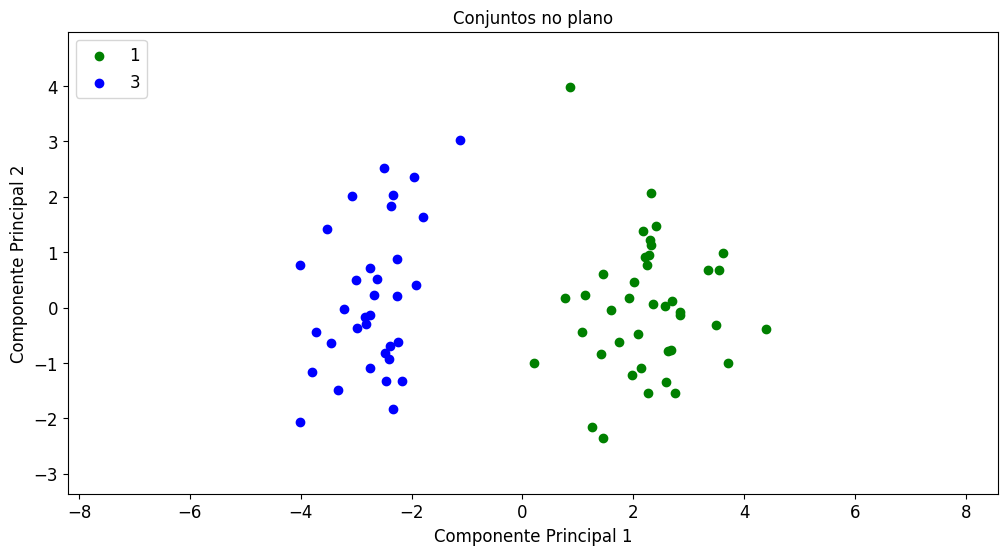

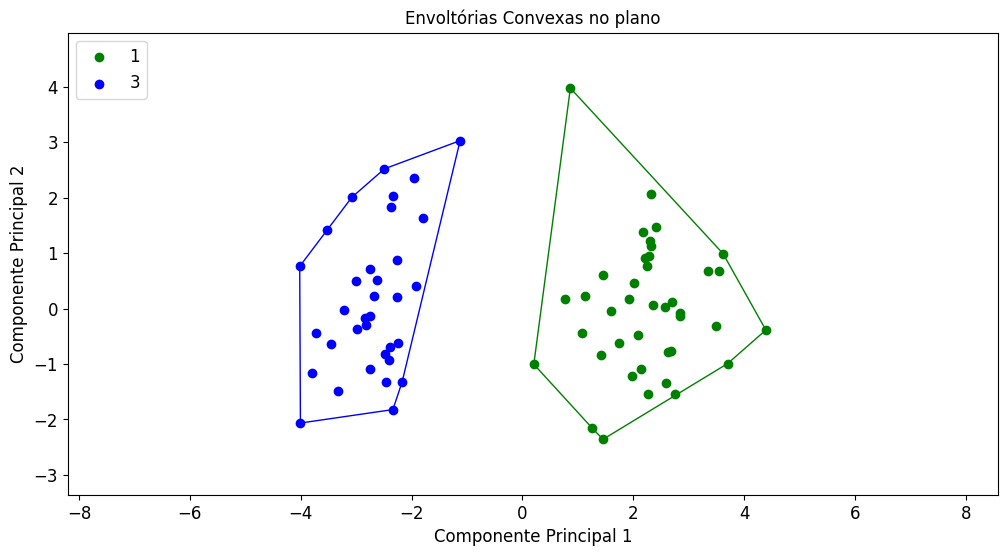

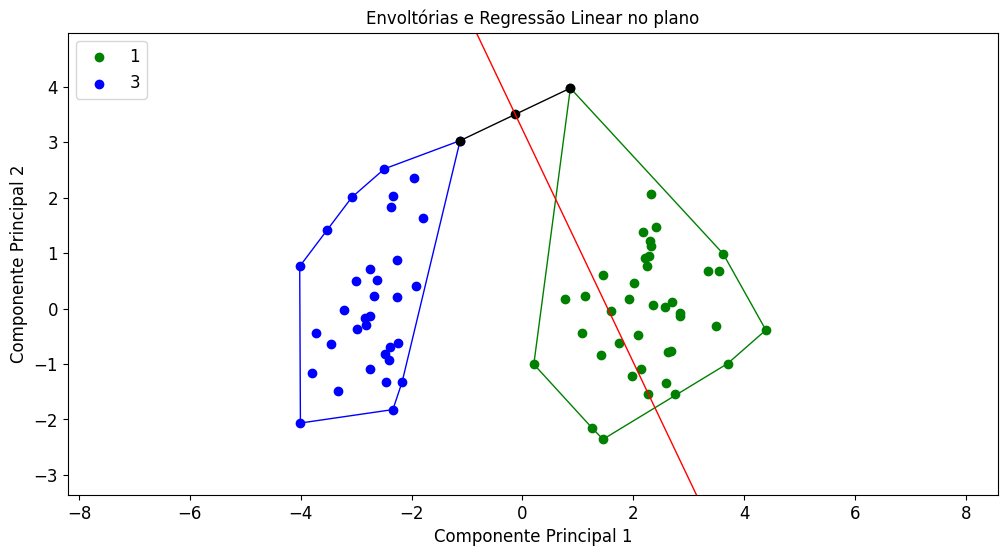

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


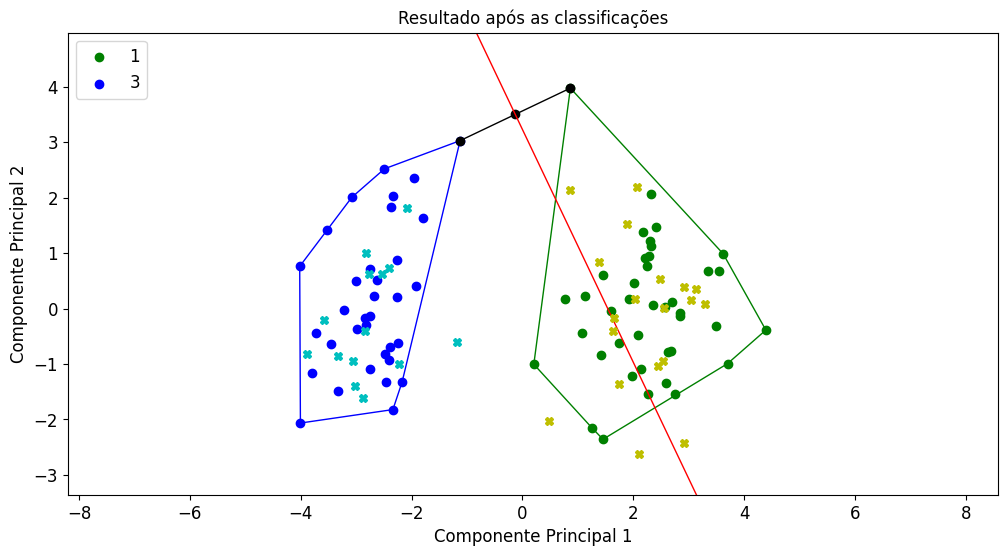

As métricas obtidas para essas classificações foram:
Precisão: 78.95%
Revocação: 100.00%
F1-Score: 88.24%


In [18]:
# Listando as features e as classes
features = ['Alcohol', 'MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium',
            'TotalPhenols', 'Flavanoids', 'NonflavanoidsPhenols', 'Proanthocyanins',
            'ColorIntensity', 'Hue', 'OD280/OD315', 'Proline']
classes = [1, 3]

construct_and_classify(features, classes, wine_df)

## __Monk-2__

Para o PCA foi possível passar todos os atributos do dataset (todos numéricos). Além disso, como só existem duas classificações possíveis para o dataset, não haviam escolhas para tentar variar e obter dois conjuntos linearmente separáveis (para fins didáticos, testar o algoritmo, etc).

Ademais, assim como para o dataset __Titanic__ (que ainda vai ser analisado nas células posteriores), esse dataset não se comporta muito bem com apenas duas componentes principais do PCA. A intuição que temos é que seriam necessárias mais dimensões para conseguir separar melhor os dados. Com os resultados que obtivemos, não foi possível fazer nenhuma classificação, apenas conseguimos gráficos um tanto quanto diferentes (PCA mostra que as classes são completamente sobrepostas para duas dimensões).

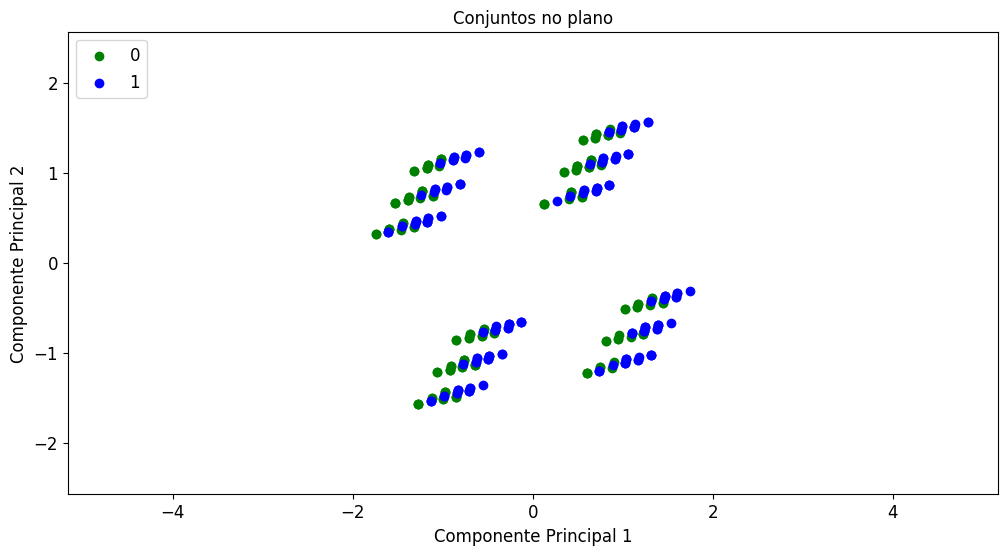

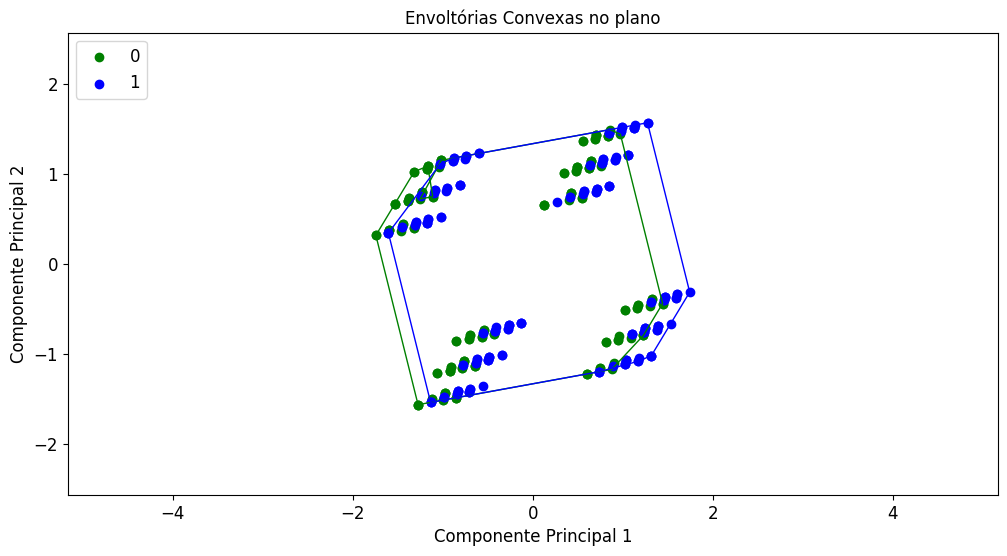

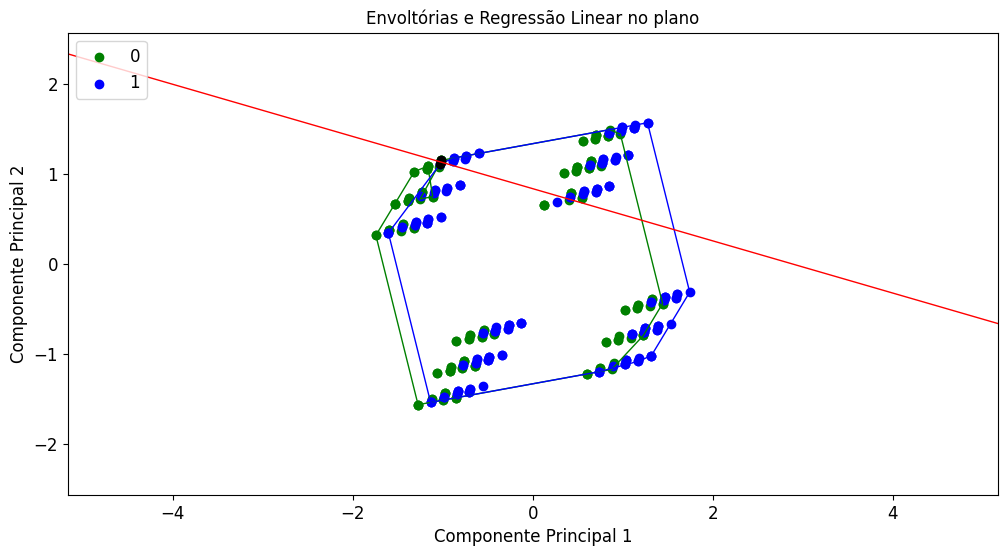

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


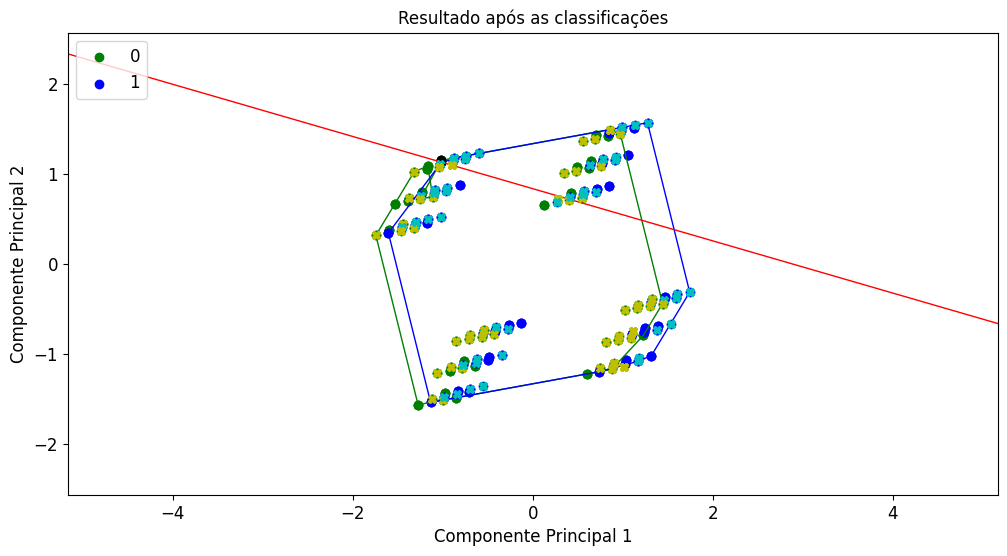

As métricas obtidas para essas classificações foram:
Precisão: 21.21%
Revocação: 40.00%
F1-Score: 27.72%


In [19]:
# Listando as features e as classes
features = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
classes = [0, 1]

construct_and_classify(features, classes, monk_2_df)

## __Page Blocks__

Para esse dataset, todos os atributos puderam ser utilizados para compor o PCA. No entanto, apesar de possuir várias classes possívels, nenhuma combinação dois-a-dois resultou em dois conjuntos linearmente separáveis. Portanto, não foi possível classificar amostras para ele, apenas visualizar os plots dos conjuntos no plano, juntamente com as envoltórias convexas.

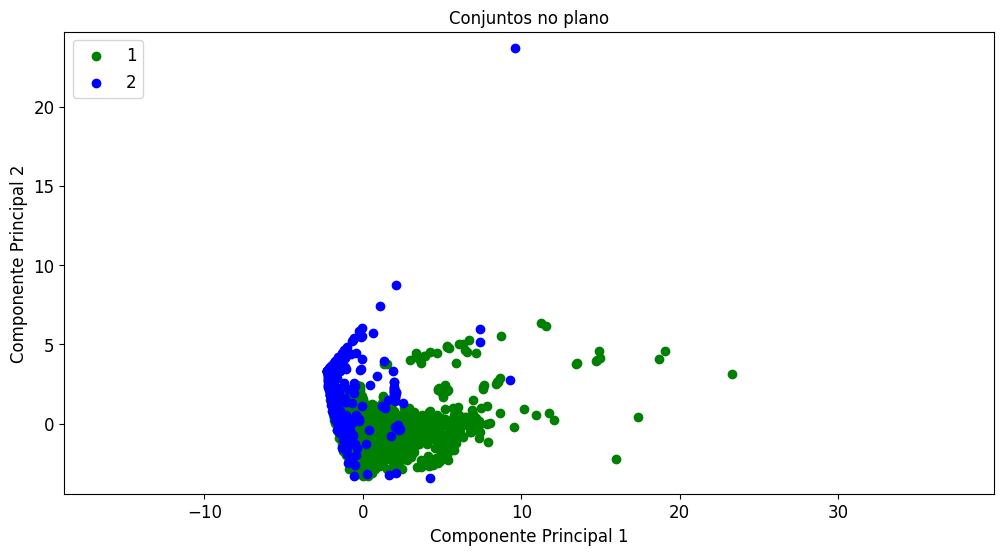

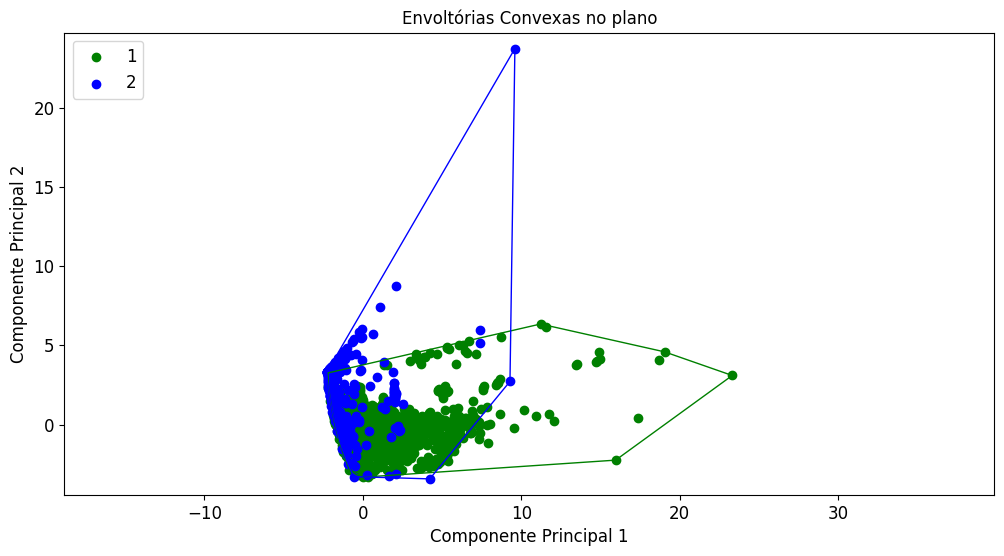

UnboundLocalError: local variable 'b0' referenced before assignment

In [20]:
# Listando as features e as classes
features = ['Height', 'Lenght', 'Area', 'Eccen', 'P_black', 'P_and', 'Mean_tr', 'Blackpix', 'Blackand', 'Wb_trans']
classes = [1, 2]

construct_and_classify(features, classes, page_blocks_df)

## __Magic__

Assim como para os últimos datasets, as componentes principais obtidas com o PCA mostraram que duas dimensões apenas não é o suficiente para separar linearmente ambas as classes. Como existiam apenas duas classes para esse dataset, também não havia muitas modificações possíveis para tentar separar as classes de alguma forma: para duas componentes, pelo menos, as classes são sobrepostas e não há o que possa ser feito.

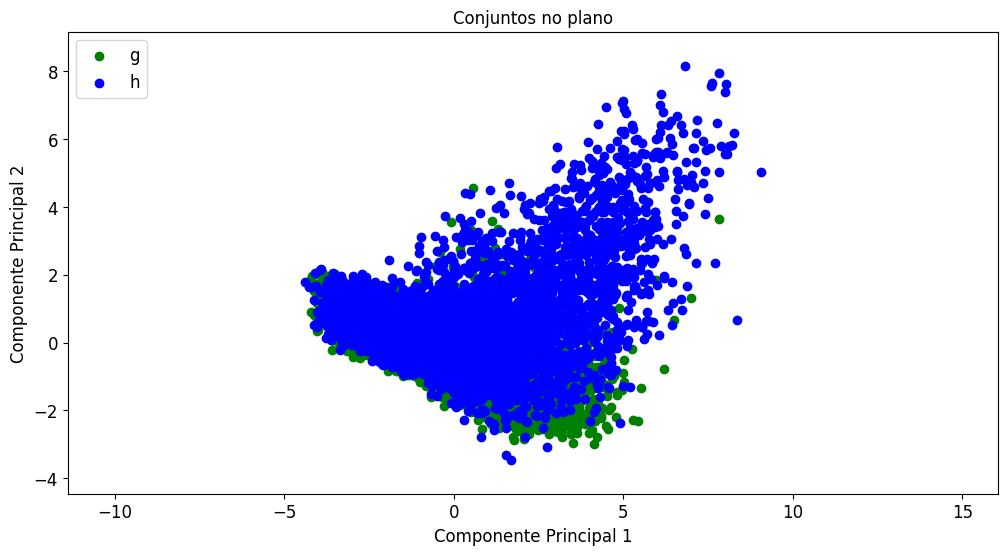

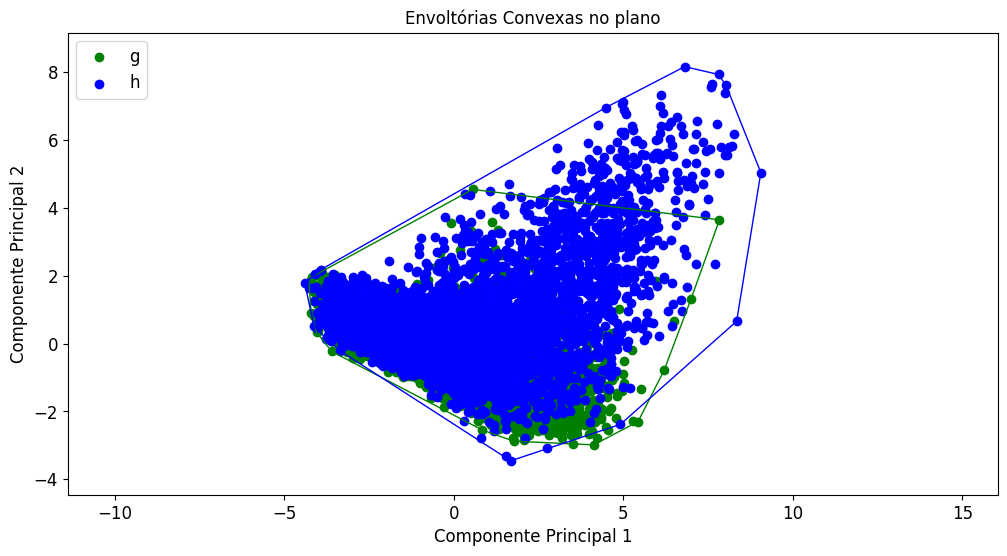

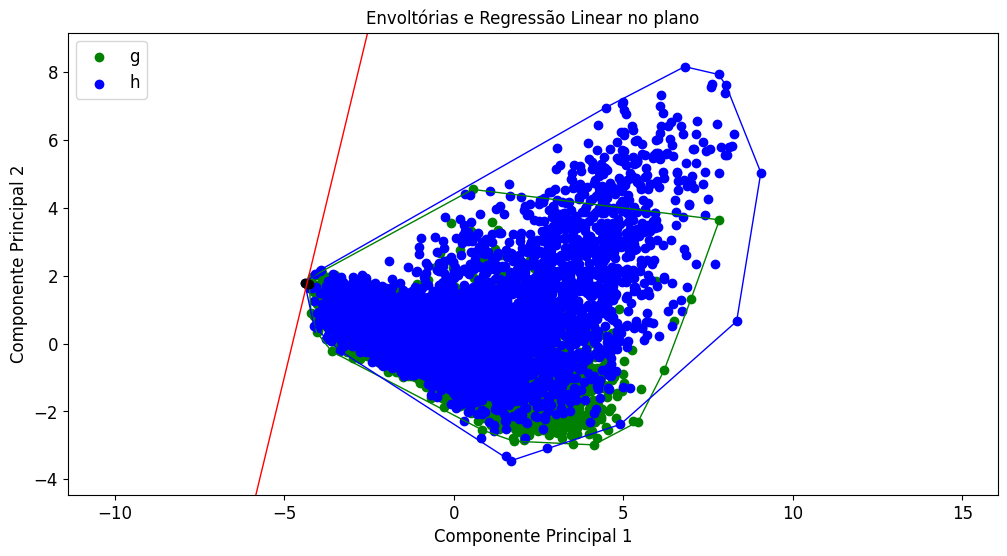

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


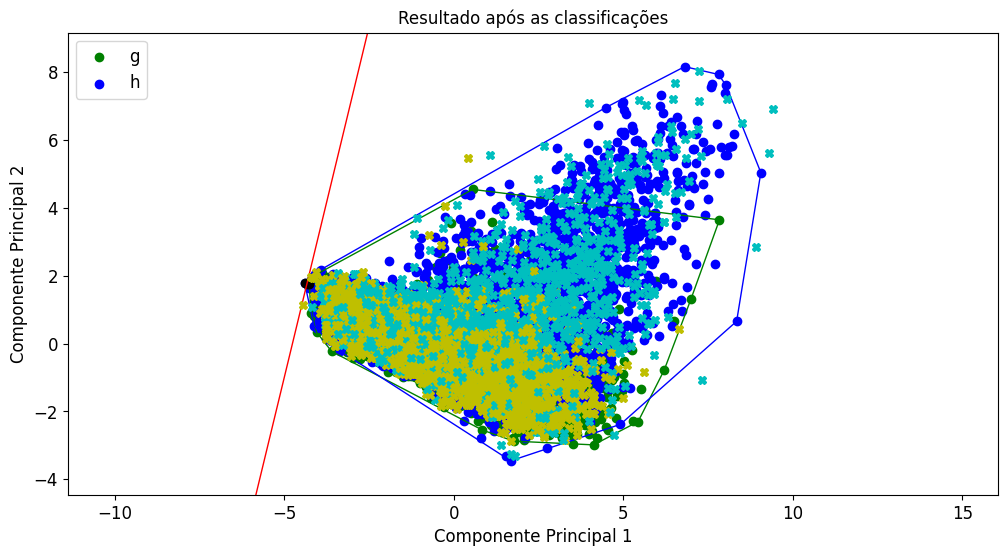

As métricas obtidas para essas classificações foram:
Precisão: 100.00%
Revocação: 64.70%
F1-Score: 78.57%


In [24]:
# Listando as features e as classes
features = ['FLength', 'FWidth', 'FSize', 'FConc', 'FConc1', 'FAsym', 'FM3Long', 'FM3Trans', 'FAlpha', 'FDist']
classes = ['g', 'h']

construct_and_classify(features, classes, magic_df)

## __Iris__

Para o dataset __Iris__, escolhemos de maneira arbitrária duas classes presentes nesse dataset: _Iris-setosa_ e _Iris-virginica_. O principal motivo da escolha foi para que pudéssemos selecionar propositalmente duas classes linearmente separáveis. Como a maioria dos datasets não é linearmente separável, para fins didáticos e para que o processor pudesse ser avaliado na prática, consideramos um par de classes que favorecesse a separabilidade linear. Portanto, para essa classificação, há algum viés nas amostras e, consequentemente, nos resultados.

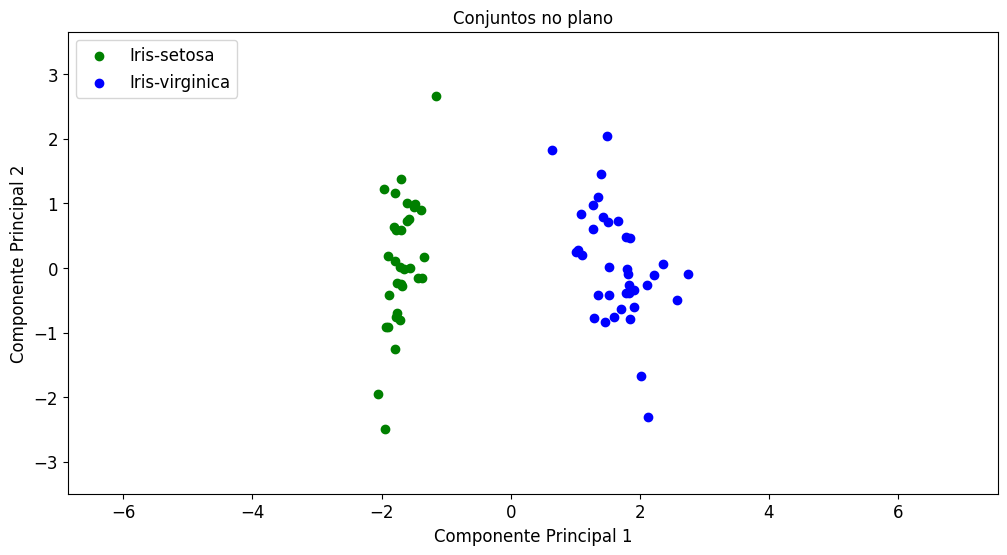

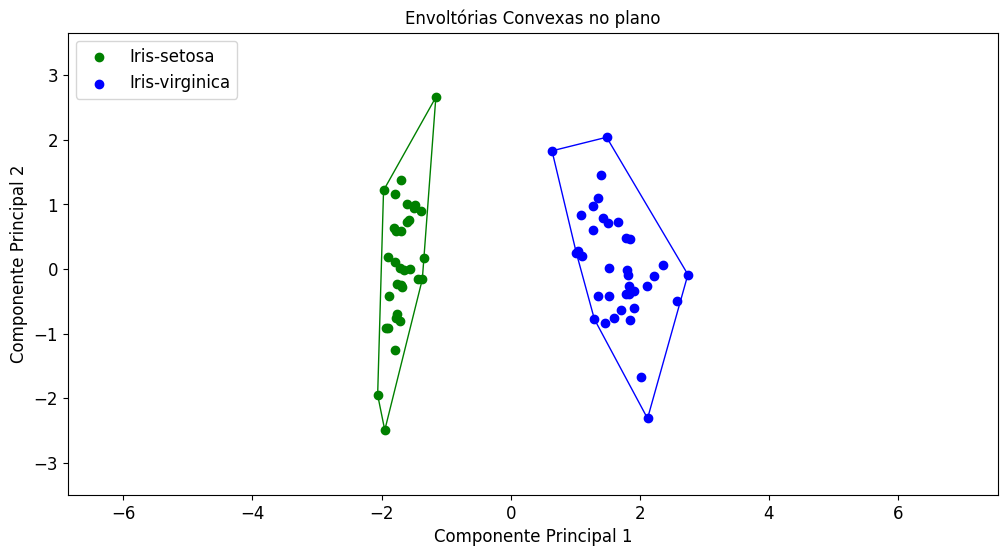

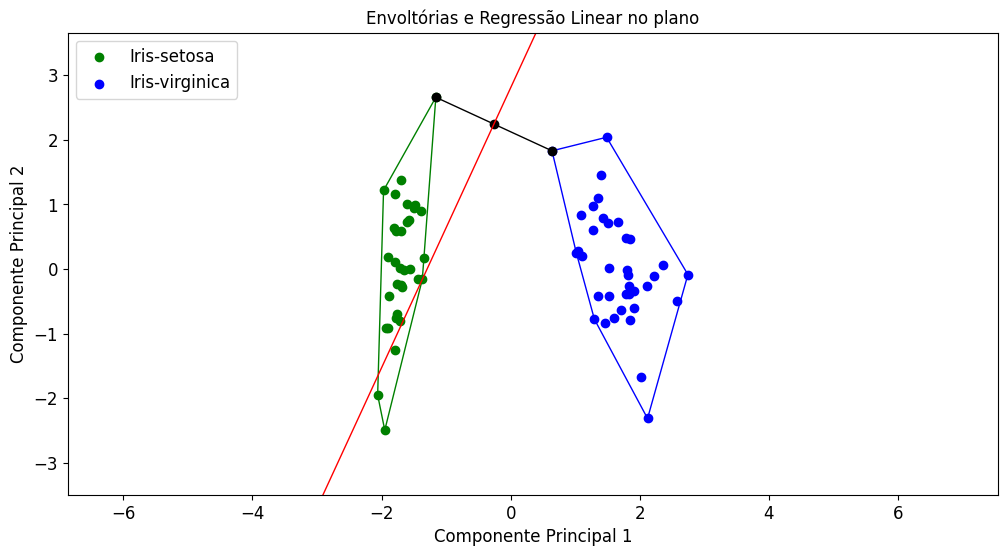

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


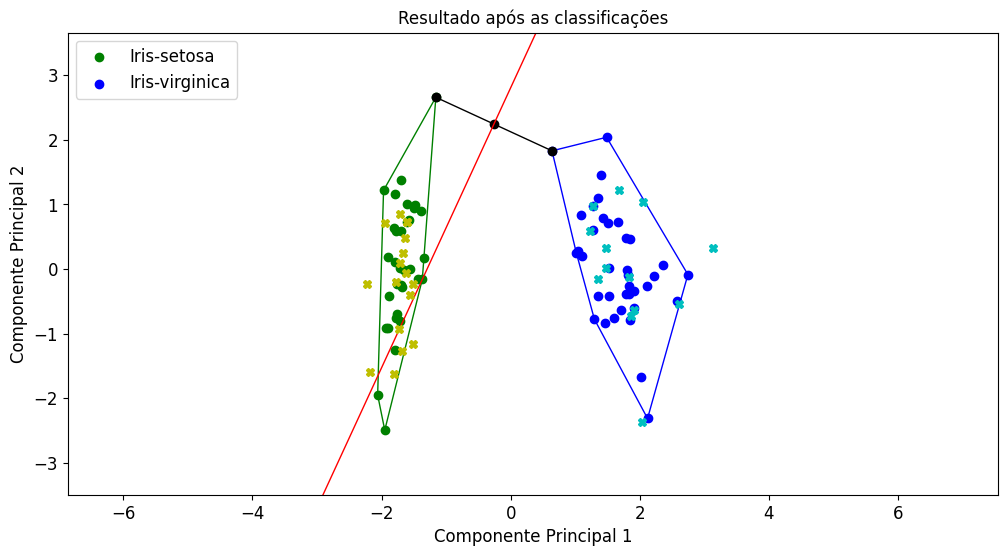

As métricas obtidas para essas classificações foram:
Precisão: 76.47%
Revocação: 100.00%
F1-Score: 86.67%


In [21]:
# Listando as features e as classes
features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
classes = ['Iris-setosa', 'Iris-virginica']

construct_and_classify(features, classes, iris_df)

## __Haberman__

Nesse dataset, as duas classes consistem em uma nuvem de pontos praticamente sobreposta, portanto não foi possível realizar a classificação das amostras de teste para o dataset.

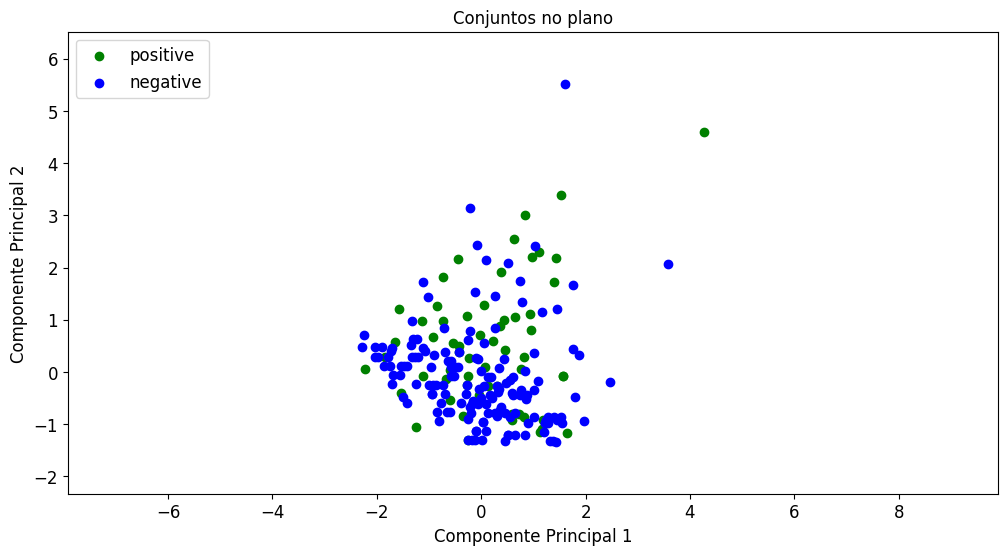

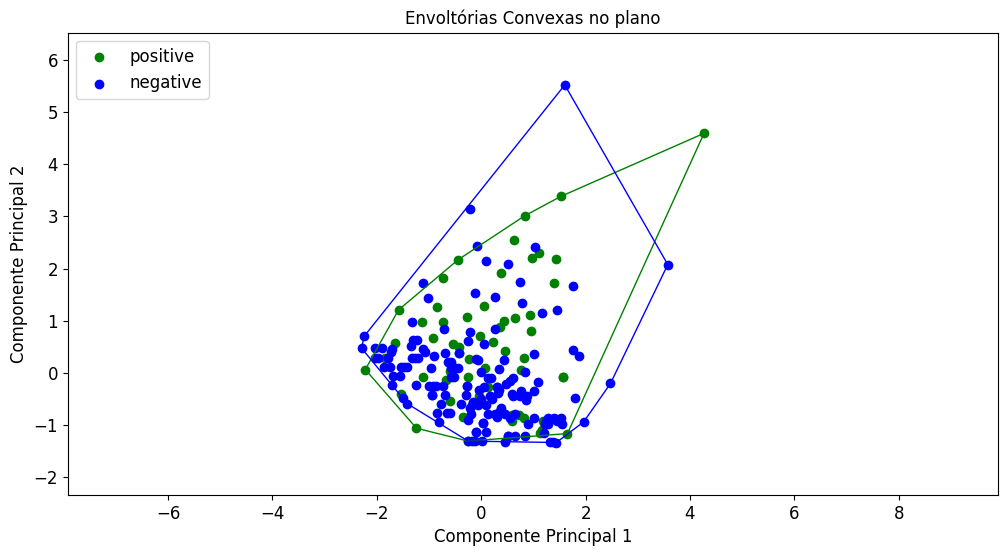

UnboundLocalError: local variable 'b0' referenced before assignment

In [22]:
# Listando as features e as classes
features = ['Age', 'Year', 'Positive']
classes = ['positive', 'negative']

construct_and_classify(features, classes, haberman_df)

## __Hayes Roth__

Para esse dataset, também não existiam muitas escolhas além de visualizar as nuvens de pontos possíveis para cada uma das classes. Apesar de haverem mais de 2 classes, nenhuma dupla de combinações possíveis consistiam em conjuntos linearmente separáveis, o algoritmo apenas retorna que os conjuntos possuem interseção e não é possível classificar amostras nele.

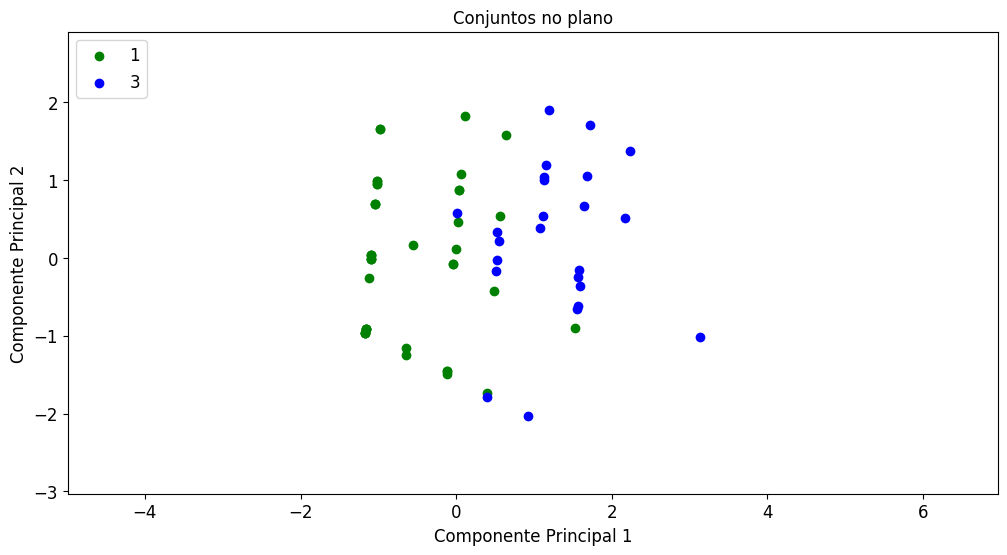

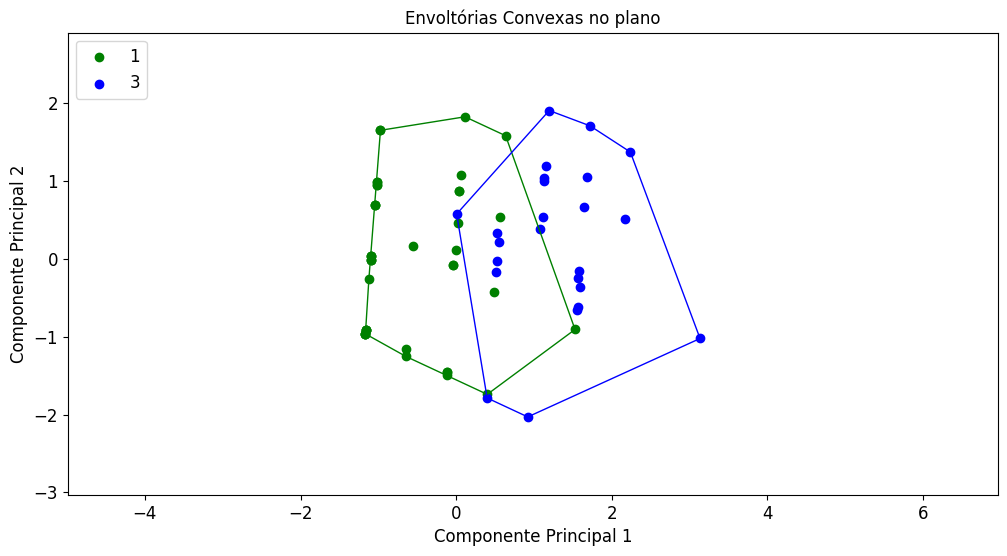

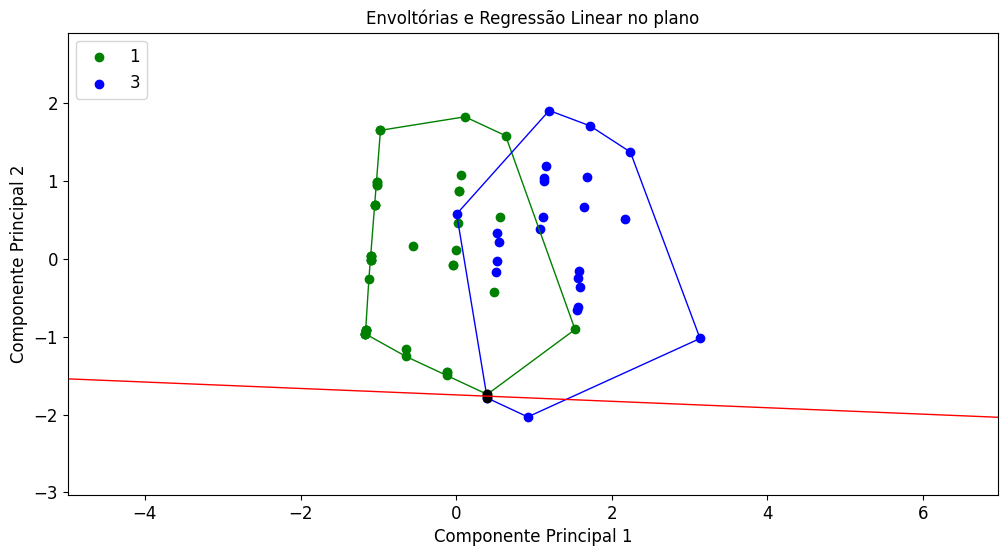

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


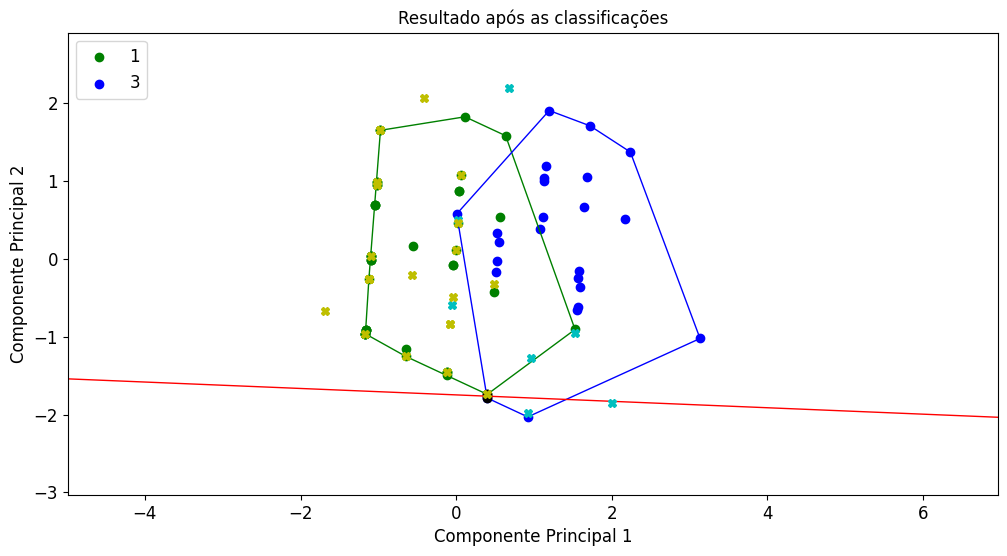

As métricas obtidas para essas classificações foram:
Precisão: 100.00%
Revocação: 81.48%
F1-Score: 89.80%


In [25]:
# Listando as features e as classes
features = ['Hobby', 'Age', 'EducationalLevel', 'MaritalStatus']
classes = [1, 3]

construct_and_classify(features, classes, hayes_roth_df)

## __Banana__

Esse dataset é mais simples, possui apenas dois atributos e duas classes. Por isso, não existe muita variação ou técnica para tentar contornar a interseção entre as classes, de modo a tentar verificar o algoritmo de classificação funcionando para o dataset. Apenas podemos observar que as classes são praticamente sobrepostas uma sobre a outra.

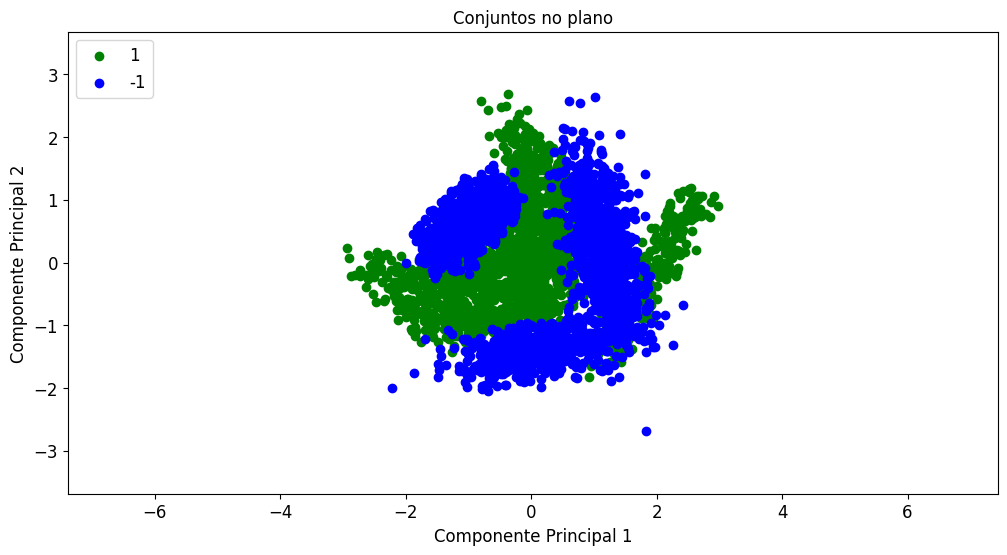

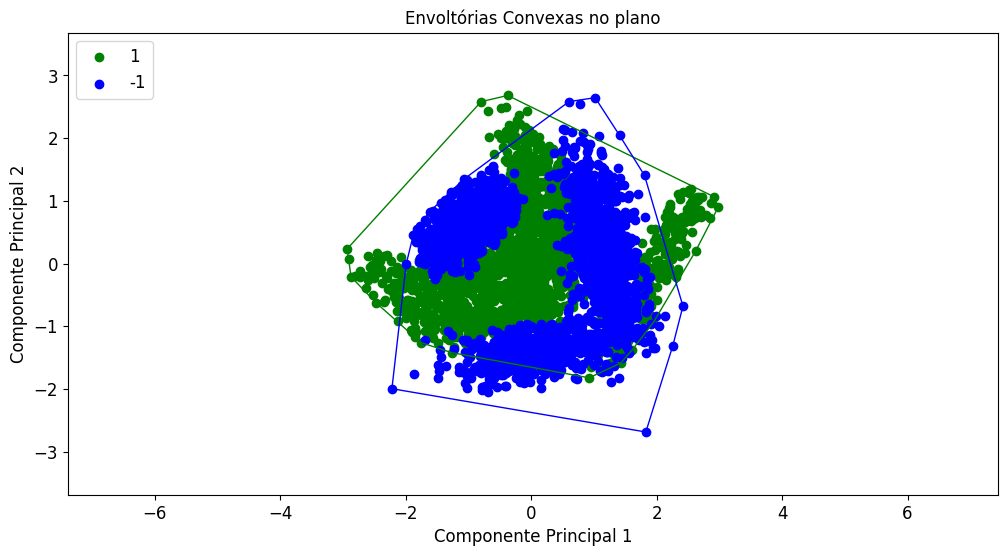

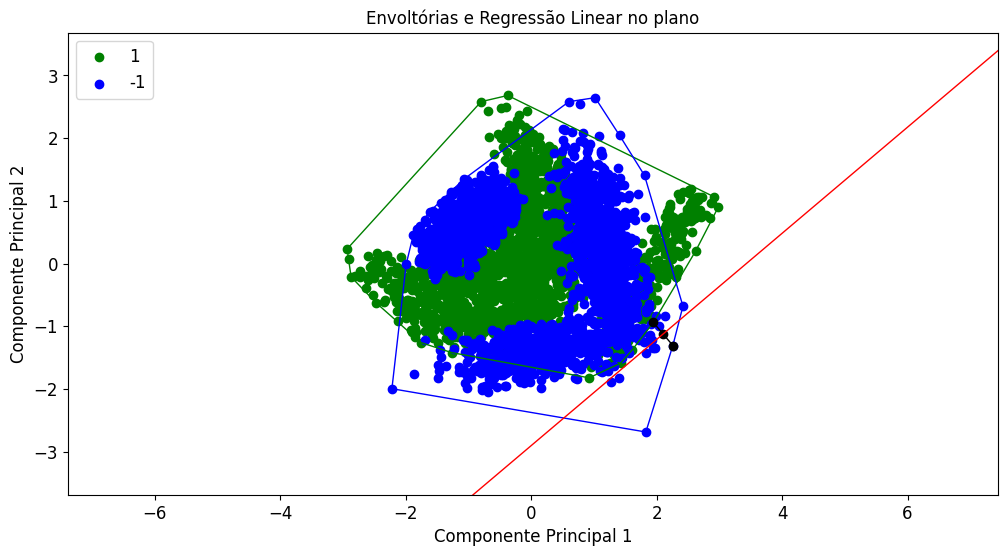

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


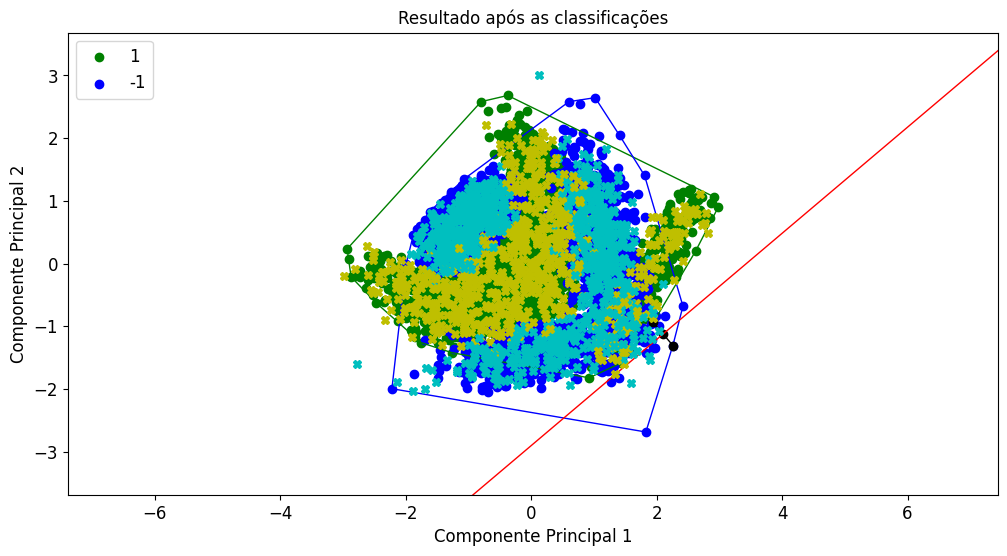

As métricas obtidas para essas classificações foram:
Precisão: 100.00%
Revocação: 44.46%
F1-Score: 61.55%


In [23]:
# Listando as features e as classes
features = ['At1', 'At2']
classes = [1, -1]

construct_and_classify(features, classes, banana_df)

## __Letter__

Para esse dataset, todos os atributos são numéricos e podem ser considerados para o PCA. No entanto, quanto as classes disponíveis, foram realizados alguns testes mas todas as duplas de letras apresentavam alguma interseção na nuvem de pontos. De qualquer forma, o _array_ __classes__ pode ser modificado, trocando as letras escolhidas por outras letras em maíusculo do alfabeto para que suas nuvens de pontos possam ser analisadas.

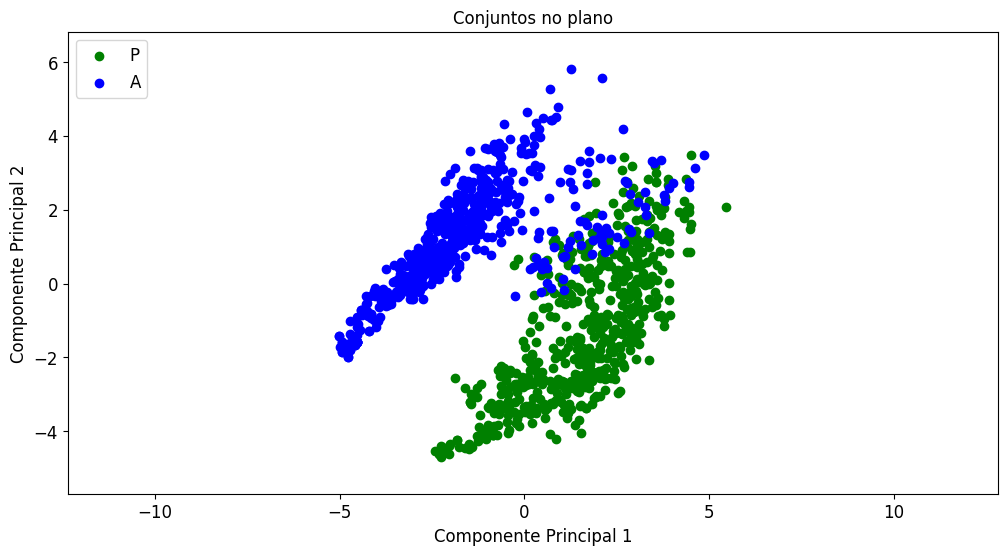

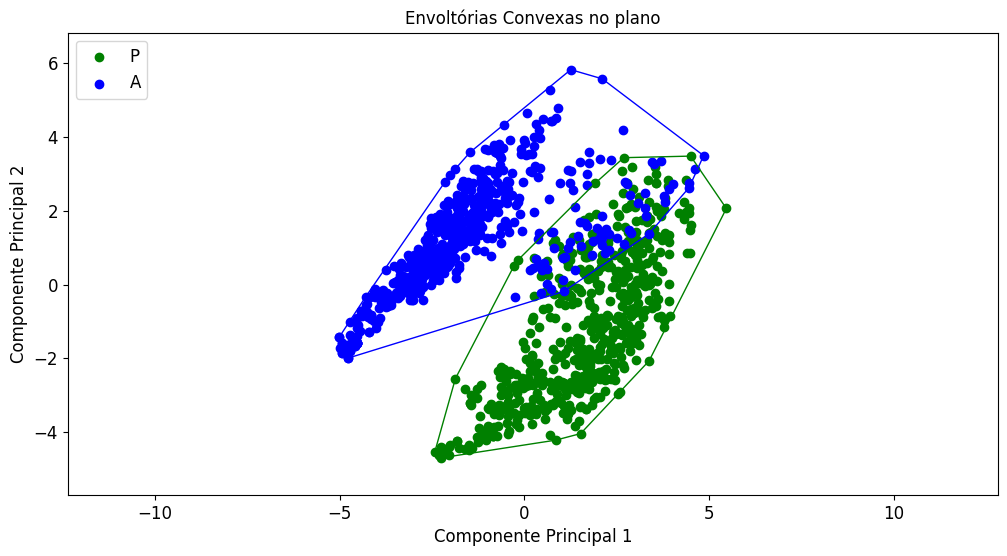

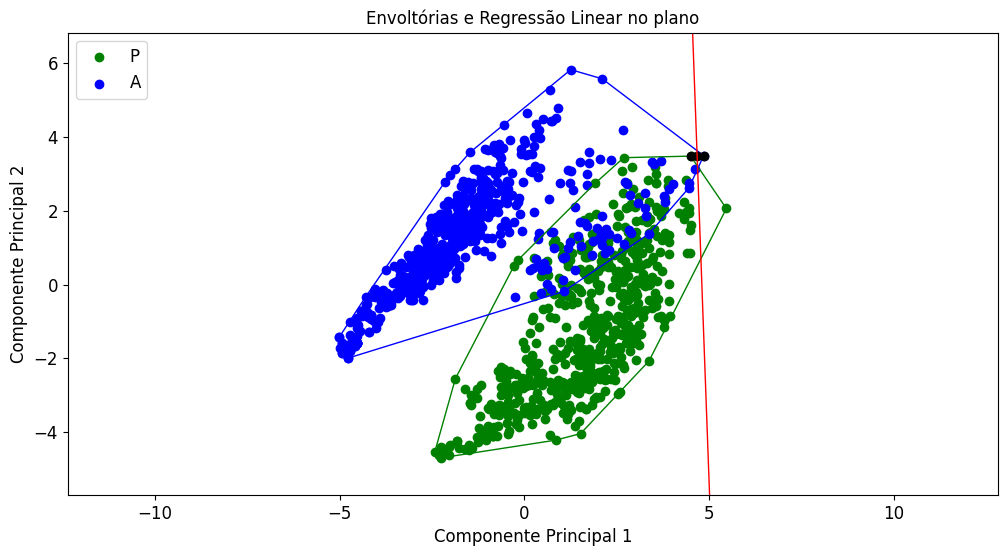

Após a classificação, o resultado obtido foi o seguinte
(pontos que estão do outro lado da reta com cor diferente são pontos que foram classificados incorretamente):


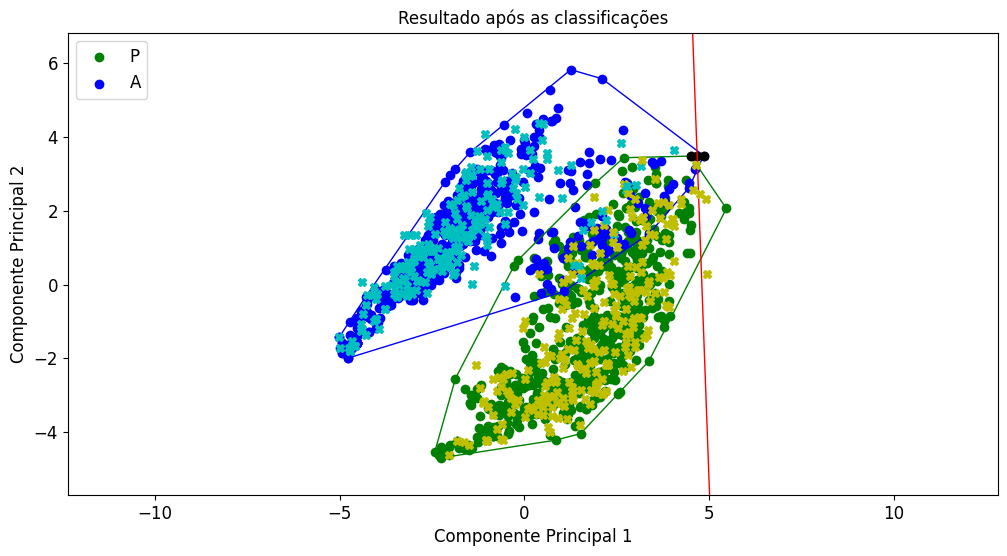

As métricas obtidas para essas classificações foram:
Precisão: 98.79%
Revocação: 51.37%
F1-Score: 67.59%


In [26]:
# Listando as features e as classes
features = ['X-box', 'Y-box', 'Width', 'High', 'Onpix', 'X-bar', 'Y-bar', 'X2bar',
            'Y2bar', 'Xybar', 'X2ybr', 'Xy2br', 'X-ege', 'Xegvy', 'Y-ege', 'Yegvx']
classes = ['P', 'A']

construct_and_classify(features, classes, letter_df)

## __Titanic__

Para o dataset __Titanic__, como só haviam duas classificações possíveis: __1__ e __-1__ (que indica que a pessoa sobreviveu ou não sobreviveu, respectivamente); todas as classes foram consideradas.

Os plots realizados para esse dataset são um tanto quanto diferentes, visto que os pontos de ambas as classes coincidem, quando analisamos a disposição deles no plano após o PCA. Essa situação indica que, com os dados disponíveis no dataset, não há diferenciação entre as pessoas que sobreviveram ou não sobreviveram ao incidente, ou seja, não existe alguma característica mapeada no dataset que seja um atributo decisivo para separar essas classes no plano.

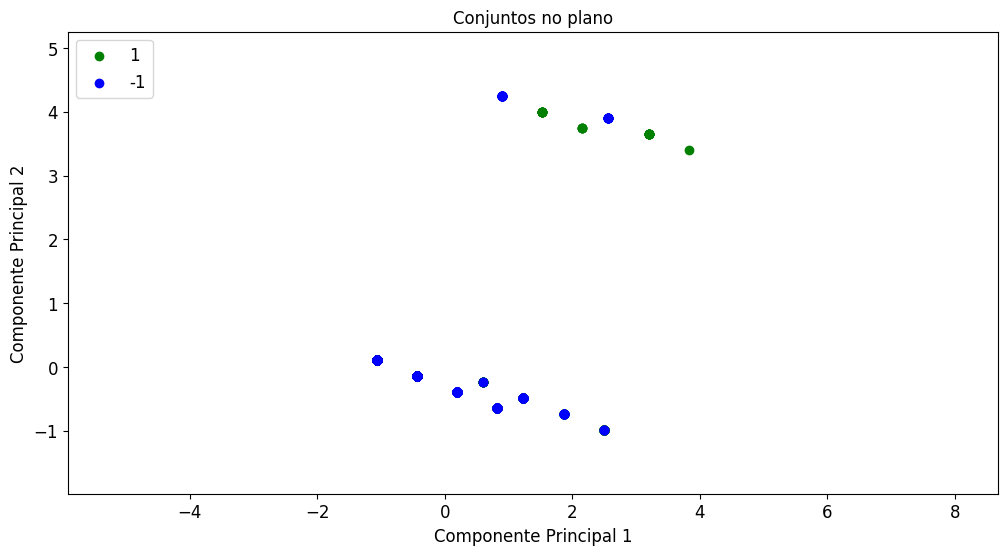

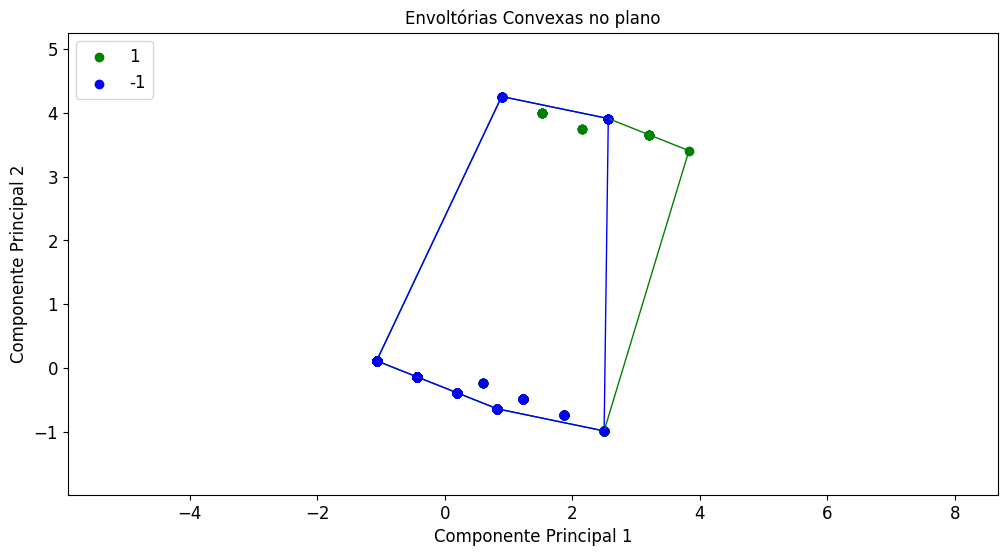

UnboundLocalError: local variable 'b0' referenced before assignment

In [27]:
# Normalizando os valores para fazer o PCA

features = ['TicketClass', 'Age', 'Sex']
classes = [1, -1]

construct_and_classify(features, classes, titanic_df)

## __Resultados__

Após a experimentação, alguns resultados e conclusões puderam ser obtidas. Apesar de dez datasets diferentes terem sidos analisados, muitos deles não eram linearmente separáveis, o que impedia o prosseguimento para as classificações e, consequentemente, a avaliação da qualidade do classificador proposto. No entanto, para àqueles datasets onde foi possível avaliar o classificador, foram obtidos resultados surpreendentementes, dado a simplicidade do método. As métricas calculadas apontam que a precisão, revocação e F1-Score para esses casos foi relativamente boa e, através dos plots pós classificação, foi possível confirmar que poucos erros aconteceram, de fato. No entanto, há um certo viés nesses resultados, visto que para favorecer a separabilidade linear algumas classes foram propositalmente escolhidas para que a classificação pudesse ocorrer.

No geral, o caráter dessa experimentação não era ser tão fiel ao conteúdo real do dataset, e sim mostrar de maneira didática o processo de classificação de amostras e o método proposto para classificação como um todo, assim como foi especificado nos motivos da escolha das classes para cada dataset. Assim, mesmo que com poucos exemplos, os resultados foram interessantes e demonstram que, para conjuntos de dados simples e preferencialmente bem divididos no espaço, por mais simplório que seja o método de classificação, ele pode ser bem útil, visto que pode ser executado de maneira imediata, diferentemente de algoritmos de aprendizado de máquina que, dependendo do dataset e da rede neural proposta, podem demorar muito tempo no processo de treinamento e, por conseguinte, serem inviáveis para determinados tipos de aplicação.

## __Conclusão__

Neste trabalho foi desenvolvido um classificador supervisionado a partir de conceitos de geometria computacional. O classificador propriamente não é muito eficaz, visto que, atualmente, existem estratégias com acurácia maior e menos restrições para classificação (mesmo fora do campo de _machine learning_, existem algoritmos também inspirados em geometria computacional que utilizam estratégias mais sofisticadas para dividir e classificar datasets). Apesar disso, para os datasets que puderam ser classificados, foi muito interessante observar o seu funcionamento e, junto disso, suas limitações (desde os conjuntos não serem linearmente separáveis até a reta classificadora cortar uma das envoltórias e, por causa disso, muitos pontos que estavam nesse região separada foram classificados incorretamente).

Contudo, a construção desse regressor foi muito importante para a fixação dos conceitos e algoritmos abordados nas aulas sobre geometria computacional. Além disso, foi possível perceber que os algoritmos e primitivas geométricas tem aplicações que vão muito além das aplicações clássicas e conhecidas para geometria computacional, o que incentivou uma percepção diferente em relação à abstração e solução de problemas computacionais, de modo geral.

## __Referências__

Vimieiro, R. (2022). _Slides sobre Geometria Computacional da disciplina de Algoritmos II_. Departamento de Ciência da Computação - Universidade Federal de Minas Gerais.

KEEL. (2018). _Standard Classification data sets_. URL<[https://sci2s.ugr.es/keel/category.php?cat=clas#inicio](https://sci2s.ugr.es/keel/category.php?cat=clas#inicio)>. Acesso em 12 de out. de 2022.

Wikipedia. (2022). _Precisão e revocação_. URL: <[https://pt.wikipedia.org/wiki/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o](https://pt.wikipedia.org/wiki/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o)>. Acesso em 27 de out. de 2022.

Wikipedia. (2022). _Principal component analysis_. URL: <[https://en.wikipedia.org/wiki/Principal_component_analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)>. Acesso em 16 de out. de 2022.

Bertan, E. (2020). _O que é Precisão e Revocação_. Medium. URL: <[https://medium.com/computando-arte/o-que-%C3%A9-precis%C3%A3o-e-revoca%C3%A7%C3%A3o-b0b991b67cde](https://medium.com/computando-arte/o-que-%C3%A9-precis%C3%A3o-e-revoca%C3%A7%C3%A3o-b0b991b67cde)>. Acesso em 27 de out. de 2022.

Allwright, S. (2022). _What is a good F1 score and how do I interpret it?_. Site pessoal. URL: <[https://stephenallwright.com/good-f1-score/](https://stephenallwright.com/good-f1-score/)>. Acesso em 27 de out. de 2022.